In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

In [2]:
BES_data_folder = "../BES_analysis_data/"
BES_code_folder = "../BES_analysis_code/"

In [3]:
%%time
# Load BES Panel for Wave 8
BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta")
#(31409, 733)

# BES_Panel = pd.read_stata(BES_data_folder+BES2015_W8_v1.6.dta")

print( BES_Panel.shape )

(31409, 733)
Wall time: 13.3 s


In [105]:
# # Select only respondents from England who answer Stay/Remain to euVote
# England = (BES_Panel["country"]=="England").values
# print ( "respondents not from England: ", sum(BES_Panel["country"]!="England") )
# Remain  = (BES_Panel["euRefVote"].cat.codes==0).values
# Leave   = (BES_Panel["euRefVote"].cat.codes==1).values
# print ( "respondents not Remain/Leave: ", len(BES_Panel[~(Remain | Leave)]) )
# BES_reduced = BES_Panel[England & (Remain | Leave)]
# BES_reduced = BES_reduced.drop("country",axis=1)
# print( BES_reduced.shape )


In [4]:
England_inds = BES_Panel[BES_Panel["country"]=="England"].index
print ( "respondents not from England: ", len(BES_Panel) - len(England_inds) )
Remain_inds  = BES_Panel[ BES_Panel["euRefVote"].cat.codes==0 ].index
Leave_inds   = BES_Panel[ BES_Panel["euRefVote"].cat.codes==1 ].index
Notvoters_inds  = BES_Panel[ BES_Panel["euRefVote"].cat.codes==2 ].index
Dontknow_inds   = BES_Panel[ BES_Panel["euRefVote"].cat.codes==3 ].index
print ( "respondents not Remain/Leave: ", len(BES_Panel) - len(Remain_inds) - len(Leave_inds) )
Leave_Remain_inds = pd.Index( np.concatenate( (Leave_inds, Remain_inds), axis=0 ) )
EngRemLea_inds = pd.Index( np.intersect1d( England_inds, Leave_Remain_inds ) )


respondents not from England:  11944
respondents not Remain/Leave:  2344


In [107]:
# short-hand if you want to try non-reduced version
# BES_reduced = BES_Panel

In [108]:
%%time
# changing the order of some sets of categories
change_cat_dict = {"Bad time to buy|Good time to buy|Neither good nor bad time to buy|Don't know": ["Bad time to buy",
                                                                                                    "Neither good nor bad time to buy",
                                                                                                    "Good time to buy",
                                                                                                    "Don't know"],
                   "Larger|Smaller|About the same|Don't know": ["Larger", "About the same", "Smaller"],
                   "Yes|No|99.0":       ['No', 'Yes', '99.0'],
                   "Yes|No|Don't know": ['No', 'Yes', "Don't know"],
                   "Yes|No" :           ['No', 'Yes'],
                   "Yes, voted|No, did not vote|Donâ??t know" : ['No, did not vote', 'Yes, voted', 'Donâ??t know'],
                   "Yes, voted|No, did not vote|Don?t know"   : ['No, did not vote', 'Yes, voted', 'Don?t know'],                   
                   "I would/will not vote|Leave the EU|Stay/remain in the EU|Don't know": ['Stay/remain in the EU',
                                                                                           'Leave the EU', 'I would/will not vote', "Don't know"],
                   "Mainly leave|Mainly remain|Fairly evenly divided|Don't know": ["Mainly remain",
                                                                                   "Fairly evenly divided", "Mainly leave", "Don't know"],
                   'An individual share in a company|A portfolio of different company shares|The risk is the same|Don\x92t know|Prefer not to say':
                       ['An individual share in a company', 'The risk is the same', 'A portfolio of different company shares'],
                   "No, I have never been a member|Yes, I am a member of a party|I am not a member now but I used to be|Don't know":
                       ['No, I have never been a member', 'I am not a member now but I used to be', 'Yes, I am a member of a party', "Don't know"],
                   "Never or practically never|Less often than once a year|Less often but at least once a year|Less often but at least twice a year|Less often but at least once a month|Less often but at least once in two weeks|Once a week or more|Varies too much to say|I am not religious|Don't know": ['I am not religious', 'Never or practically never', 'Less often than once a year', 'Less often but at least once a year', 'Less often but at least twice a year', 'Less often but at least once a month', 'Less often but at least once in two weeks', 'Once a week or more']
                  }

                   
Weasel_answers = ["Don't know", 'Do\x92t know', 'Dont know', 'Donât know', 'Don??t know',
                  "Prefer not to say", "Prefer not to answer", "Refused", "Unknown",
                  "Neither", "Other", "I would/will not vote", "Will not vote",
                  "I would not vote", "It depends", "Other",
                  "Don’t follow politics on Facebook", "Don't follow politics on twitter",
                  "Yes, other", "Haven't thought about it",
                  "There wasn't a local election in my area", "No, haven't received it",
                  "I don't know what was negotiated", "I never received a response",
                  "There are not local elections in my area", "Can't remember",
                  "Varies too much to say", "Will not state a choice",
                  "All leaders equally good", "They are not eligible to vote",
                  "There are not local elections in my area"]

Weasel_number_answers = [ "9999.0", "997.0", "222.0", "99.0", "0.0" ]

# ADD
# 9999.0
# 99.0 - unfortunately, it also appears in some numerical answers
# Probably need to have a separate check - e.g. is the preceding category "98.0"/"98"

# non-answer answers
Weasel_set = set(Weasel_answers) # gets rid of duplicates!


## define 'de_Weasel' function to remove Weasel Words from lists of options
## ie. "Yes|No|Don't know" -> "Yes|No"

Weasel_answers = ["Don't know", 'Don?t know', 'Donâ??t know', 'Do\x92t know', 'Dont know', 'Donât know', "Prefer not to say", "Prefer not to answer", "Refused", "Unknown", "Neither", "Other", "I would/will not vote", "Will not vote", "No - not decided", "I would not vote", "It depends", "Other", "Don’t follow politics on Facebook", "Don't follow politics on twitter", "9999.0", "997.0", "222.0", "Yes, other", "Haven't thought about it", "There wasn't a local election in my area", "No, haven't received it", "I don't know what was negotiated", "I never received a response", "There are not local elections in my area", "Can't remember", "Varies too much to say" ]

# non-answer answers
Weasel_set = set(Weasel_answers) # gets rid of duplicates!

# remove weasel phrases
def de_weasel(ques): 

    return "|".join( [x for x in ques.split("|") if x not in Weasel_answers] )

# reorder categories
def re_order(ques):
    if ques in change_cat_dict.keys():
        return "|".join( change_cat_dict[ques] )
    else:
        return ques

def de_num_el(el):
    if el.isdigit():
        el = "%.1f" % int( el )
    return el

def de_number(ques):
    return "|".join( [de_num_el(x) for x in ques.split("|")] )

def de_num(ques):
    return [de_num_el(x) for x in ques]

def floatable(flt):
    try:
        float(flt)
        return True
    except:
        return False

# Weasel_number_answers
# Remove 'weasel' numbers
# but only if they are the last element
# or not the last element, but the next is not a number
# to avoid catching parts of sequential numerical categories
def de_weasel_numbers(ques):
    el_list = ques.split("|")
    el_list_len = len(el_list)
    remove_list = []
    for el_pos in range( 0, el_list_len ):
        if el_list[el_pos] in Weasel_number_answers:
            # last element, or not last element but next element is a not a number
            if el_pos==(el_list_len-1) or not floatable(el_list[el_pos+1]):
                remove_list.append(el_list[el_pos])

    return "|".join( [x for x in el_list if x not in remove_list] )


# version to act directly on cat.categories array
def de_weasel_nums(el_list):

    el_list_len = len(el_list)
    remove_list = []
    for el_pos in range( 0, el_list_len ):
        if el_list[el_pos] in Weasel_number_answers:
            # last element, or not last element but next element is a not a number
            if el_pos==(el_list_len-1) or not floatable(el_list[el_pos+1]):
                remove_list.append(el_list[el_pos])

    return remove_list

# s.cat.rename_categories([1,2,3])
# EUContactRemainConW8|EUContactRemainLabW8|EUContactRemainLDW8|
# EUContactRemainSNPW8|EUContactRemainPCW8|EUContactRemainUKIPW8|
# EUContactRemainGreenW8|EUContactRemainOthW8|EUContactRemainNoneW8|
# EUContactRemainDKW8|EUContactLeaveConW8|EUContactLeaveLabW8|
# EUContactLeaveLDW8|EUContactLeaveSNPW8|EUContactLeavePCW8|
# EUContactLeaveUKIPW8|EUContactLeaveGreenW8|EUContactLeaveOthW8|
# EUContactLeaveNoneW8|EUContactLeaveDKW8

# pattern match "EUContact*****W8"
# debateOneWatchW8|debateTwoWatchW8

# "1.0|2.0|99.0" -> 

# euRefVoteSqueezeW7 "Will not vote|Yes - Leave|Yes - Remain|No - not decided"
#    -> Stay/remain in the EU|Leave the EU|I would/will not vote|Don't know
#    HMM - RENAME AND REORDER!

# miieuW7
# "Issue stated|Nothing|Don't know" -> "Issue stated|None|Don't know"
# MIIEUW8
# "1.0|Nothing|Don't know" -> "Issue stated|None|Don't know"
# partyIdEUW7|partyIdEUW8
# "Mainly leave|Mainly remain|Fairly evenly split|Don't know" -> "Mainly remain|Fairly evenly divided|Mainly leave|Don't know"
#    HMM - RENAME AND REORDER!

# 1. campaignVisionYesW3|campaignVisionNoW3, govtNatSecuritySuccessW4
# Very unsuccessful|Fairly unsuccessful|Neither successful nor unsuccessful|Fairly successful|Very successful|Don't know
# Very unsuccessful|Somewhat unsuccessful|Neither successful or unsuccessful|Somewhat successful|Very successful|Don't know

# Fairly <-> Somewhat

# 2. euroTurnoutW1, scotReferendumTurnoutW1|scotReferendumTurnoutW2|welshTurnoutW7|scotTurnoutW7, turnoutUKGeneralW1|turnoutUKGeneralW2|turnoutUKGeneralW3|turnoutUKGeneralW4|turnoutUKGeneralW5|euRefTurnoutW7|euRefTurnoutW8
# Very unlikely that I vote|Fairly unlikely|Neither likely nor unlikely|Fairly likely|Very likely that I vote|Don't know
# Very unlikely that I would vote|Fairly unlikely|Neither likely nor unlikely|Fairly likely|Very likely that I would vote|Don't know
# There are not local elections in my area
    #|Very unlikely that I will vote|Fairly unlikely|Neither likely nor unlikely|Fairly likely|Very likely that I will vote|Don't know
# Very unlikely that I will vote|Fairly unlikely|Neither likely nor unlikely|Fairly likely|Very likely that I will vote|Don't know

# "Very unlikely that I vote", "Very unlikely that I would vote" ->  "Very unlikely that I will vote" 

rename_cat_dict = {"North East|North West": [ "No", "Yes" ],
                   "1.0|2.0|99.0": ["No", "Yes", "99.0"],
                   "Will not vote|Yes - Leave|Yes - Remain|No - not decided": ['I would/will not vote', 'Leave the EU',
                                                                               'Stay/remain in the EU', "Don't know"],
                   "Issue stated|Nothing|Don't know":  ['Issue stated', 'None', "Don't know"],
                   "1.0|Nothing|Don't know":           ['Issue stated', 'None', "Don't know"],
                   "a|b|C1|C2|d|e|Refused|Unknown" : ['A', 'B', 'C1', 'C2', 'D', 'E', 'Refused', 'Unknown'],
                   "Mainly leave|Mainly remain|Fairly evenly split|Don't know": ['Mainly leave',
                                                                                 'Mainly remain', 'Fairly evenly divided', "Don't know"],
                   "Very unsuccessful|Somewhat unsuccessful|Neither successful or unsuccessful|Somewhat successful|Very successful|Don't know": ['Very unsuccessful',
                        'Fairly unsuccessful', 'Neither successful nor unsuccessful', 'Fairly successful', 'Very successful', "Don't know"],
                   "Very unlikely that I vote|Fairly unlikely|Neither likely nor unlikely|Fairly likely|Very likely that I vote|Don't know": ['Very unlikely that I will vote',
                     'Fairly unlikely', 'Neither likely nor unlikely', 'Fairly likely', 'Very likely that I will vote', "Don't know"],
                   "Very unlikely that I would vote|Fairly unlikely|Neither likely nor unlikely|Fairly likely|Very likely that I would vote|Don't know": ['Very unlikely that I will vote',
                     'Fairly unlikely', 'Neither likely nor unlikely', 'Fairly likely', 'Very likely that I will vote', "Don't know"],
                   }


def re_name(ques):
    if ques in rename_cat_dict.keys():
        return "|".join( rename_cat_dict[ques] )
    else:
        return ques


ignore_list = ['approveEUW2',
               'whichPartiesHelped_99W6',
               'partyContactGrnW1',
               'partyContactGrnW2',
               'reasonNotRegistered_noneW2',
               'partyContactGrnW3',
               'reasonNotRegistered_noneW3',
               'reasonNotRegistered_noneW4',
               'reasonNotRegistered_noneW6',
               'reasonNotRegistered_noneW7',
               'reasonNotRegistered_noneW8',
               'partyContactSNPW1',
               'partyContactSNPW2',
               'changeIssue1W9',
               'conLeaderLikeW9'
              ]

#- approveEUW2 'Strongly disapprove|Disapprove|Don't know' - should be "approve|disapprove|don't know"??? NOT SURE (distribution weird)
#- whichPartiesHelped_99W6 - answer set = ["No"]
#- partyContactGrnW1 ... reasonNotRegistered_noneW8 answer set = ["No", "Don't know"]
# -partyContactSNPW1, partyContactSNPW2 - answer set = ["Don't know"]
# -changeIssue1W9|conLeaderLikeW9 - answer set = ["No formal qualifications"]

## define 'prune' function to prune wave indicators and return question stubs
## ie. "ptvConW1|ptvLabW1" -> "ptvCon|ptvLab"

def prune(x):
    
    y= []
    for el in x.split("|"):
        match_attempt = re.match('(\w*?)_?(W[0-9]+)+' , el )   
        if match_attempt:
            el = match_attempt.groups()[0]
        y.append(el)
    # should we ditch identical repeats?
    # return "|".join(set(y)) NEEDS TO BE TESTED
    return "|".join(y)

               
def prune2(x):
    
    y= []
    for el in x.split("|"):
        match_attempt = re.match('(\w*?)_?[0-9]+' , el )   
        if match_attempt:
            el = match_attempt.groups()[0]
        y.append(el)
    # should we ditch identical repeats?
    # return "|".join(set(y)) NEEDS TO BE TESTED
    return "|".join(y)
#variable_categories

Wall time: 0 ns


In [109]:
variable_categories = pd.read_csv("question_categories_correct.csv", encoding = "ISO-8859-1")

# flipping list
var_cat_dict = dict()
for typ in [1,2,3,4,5,6]:
    e = variable_categories[variable_categories.type==typ]["column_name"].values
    var_cat_dict[typ] = [item for sublist in [i.split("|") for i in e] for item in sublist]
    
# dictionary comprehension to prune column-names to wave non-specific stubs
# list(set()) gets rid of repetitions
var_cat_dict_pruned   = {k: list(set([prune(x)  for x in v])) for k, v in var_cat_dict.items()}
var_cat_dict_pruned_2 = {k: list(set([prune2(x) for x in v])) for k, v in var_cat_dict_pruned.items()}

In [110]:
var_type = pd.DataFrame(columns = ['type'] )
# df = DataFrame(columns=('lib', 'qty1', 'qty2'))

missing_col_names = []

for col in BES_Panel.columns:
    dt =  BES_Panel[col].dtype.name # data type
    not_found = False
    if ( dt!='category' ) and ( dt!='float64' ):
        var_type.loc[col] = -1
    
    elif ( dt=='float64' ) and (col in ['personality_agreeableness',
                                        'personality_conscientiousness',
                                        'personality_extraversion',
                                        'personality_neuroticism',
                                        'personality_openness',
                                        'mapNamesW3',
                                        'riskScaleW8']):
        var_type.loc[col] = 0

    elif ( dt=='float64' ):
        var_type.loc[col] = -1

    elif ( dt=='category' ):
        not_found = True
        for typ in [1,2,3,4,5,6]:
            if prune2( prune(col) ) in var_cat_dict_pruned_2[typ]:
                var_type.loc[col] = typ
                not_found = False

    if not_found == True:
  #      print("what's up with this? " + col, prune2( prune(col) ) )
        missing_col_names.append(col)
var_type["type"] = var_type["type"].astype("int8")
missing_col_names

[]

In [111]:
if missing_col_names:

    updated_variable_categories = variable_categories.copy()

    # question	frequency	question_length	question_options	column_name	type

    for i in missing_col_names:
        str_list = [ str(cat) for cat in BES_Panel[i].cat.categories ]
        joined_list = "|".join(str_list)
        match  = (joined_list == updated_variable_categories["question"])
        # print(i, " : " , "|".join(str_list ), " : ", len(str_list) )
        if match.any(): # answer set already in records
            index = updated_variable_categories[match].index
            if len(index)>1: # answer set ("question") index should be unique!
                raise ValueError('answer set ("question") index should be unique!')

            # add column name and increase frequency
            updated_variable_categories.loc[index,"frequency"] = updated_variable_categories.loc[index,"frequency"]+1
            current_list_col_names = updated_variable_categories.loc[index,"column_name"].values[0].split("|")
            current_list_col_names.append(i)
            updated_variable_categories.loc[index,"column_name"] = "|".join( current_list_col_names )
        else: # answer set not already in records - add new line to dataframe
            df = pd.DataFrame([],  columns = updated_variable_categories.columns )

            df.loc[0] = [updated_variable_categories.shape[0],
                         joined_list,
                         1,
                         len(joined_list),
                         len(str_list),
                         i,-1]
            updated_variable_categories = updated_variable_categories.append(df, ignore_index=True)

    variable_categories = updated_variable_categories
    updated_variable_categories.to_csv("question_categories_correct_updatesneeded!.csv", encoding = "ISO-8859-1")
    
    # rerun after updating list!
    
    #variable_categories = pd.read_csv("question_categories_correct.csv", encoding = "ISO-8859-1")

    # flipping list
    var_cat_dict = dict()
    for typ in [1,2,3,4,5,6]:
        e = variable_categories[variable_categories.type==typ]["column_name"].values
        var_cat_dict[typ] = [item for sublist in [i.split("|") for i in e] for item in sublist]

    # dictionary comprehension to prune column-names to wave non-specific stubs
    # list(set()) gets rid of repetitions
    var_cat_dict_pruned   = {k: list(set([prune(x)  for x in v])) for k, v in var_cat_dict.items()}
    var_cat_dict_pruned_2 = {k: list(set([prune2(x) for x in v])) for k, v in var_cat_dict_pruned.items()}        
        
    var_type = pd.DataFrame(columns = ['type'] )
    missing_col_names = []

    for col in BES_Panel.columns:
        dt =  BES_Panel[col].dtype.name # data type
        not_found = False
        if ( dt!='category' ) and ( dt!='float64' ):
            var_type.loc[col] = -1

        elif ( dt=='float64' ) and (col in ['personality_agreeableness',
                                            'personality_conscientiousness',
                                            'personality_extraversion',
                                            'personality_neuroticism',
                                            'personality_openness',
                                            'mapNamesW3',
                                            'riskScaleW8']):
            var_type.loc[col] = 0

        elif ( dt=='float64' ):
            var_type.loc[col] = -1

        elif ( dt=='category' ):
            not_found = True
            for typ in [1,2,3,4,5,6]:
                if prune2( prune(col) ) in var_cat_dict_pruned_2[typ]:
                    var_type.loc[col] = typ
                    not_found = False

        if not_found == True:
            raise ValueError('Values still missing second time around! ', col)
    var_type["type"] = var_type["type"].astype("int8")

In [1145]:
# BES_Panel['personality_agreeableness'].value_counts()

# variable_categories["de_weaseled_questions"] = variable_categories["de_weaseled_questions"].apply(re_name)
# variable_categories["de_weaseled_questions"] = variable_categories["de_weaseled_questions"].apply(re_order)
# variable_categories["de_weaseled_questions"] = variable_categories["de_weaseled_questions"].apply(de_weasel_numbers)
# variable_categories["de_weaseled_questions"] = variable_categories["de_weaseled_questions"].apply(de_number)
# variable_categories["de_weaseled_questions"] = variable_categories["de_weaseled_questions"].apply(de_weasel)

In [112]:
%%time
BES_numeric = BES_Panel.copy()
pos = 0
for col in BES_numeric:
    print(100*pos/len(BES_numeric.columns))
    pos = pos + 1
    
    if col not in var_type["type"].index:
        print(col, " not in var_type")
        continue
    typ = var_type["type"][col]
    if (typ == -1) | (typ == 4) | (col =="id") | (typ==0) | (col in ignore_list): # skip
        continue
        #BES_numeric.drop(col,axis=1,inplace=True)
        
    #print(col)
         
    
    # force all category elements into strings
    BES_numeric[col].cat.rename_categories( BES_numeric[col].cat.categories.map(str), inplace=True )
    
    # rename categories
    
    join_list = "|".join( BES_numeric[col].cat.categories )
    if join_list in rename_cat_dict.keys():
        BES_numeric[col].cat.rename_categories(  rename_cat_dict[join_list], inplace=True )
    # update join_list!
    
    # reorder categories
    join_list = "|".join( BES_numeric[col].cat.categories )
    if join_list in change_cat_dict.keys():
#         print(col)
#         print(join_list)
#         print(change_cat_dict[join_list])
        BES_numeric[col].cat.reorder_categories( change_cat_dict[join_list], inplace=True )    
    
    # de_weasel numbers
    BES_numeric[col].cat.remove_categories( de_weasel_nums( BES_numeric[col].cat.categories ), inplace=True )
    
    # set all digits to floating point format, one decimal place
    BES_numeric[col].cat.rename_categories( de_num( BES_numeric[col].cat.categories ), inplace=True )
                                          
    # de_weasel                                   
    BES_numeric[col].cat.remove_categories( BES_numeric[col].cat.categories.intersection(Weasel_set), inplace=True )

      
        
#     elif (typ == 2):
#         new_cat_order = change_cat_dict["|".join(BES_numeric[col].cat.categories)]
#         BES_numeric[col].cat.remove_categories( BES_numeric[col].cat.categories.intersection(Weasel_set), inplace=True )
#         BES_numeric[col].cat.reorder_categories( new_cat_order, inplace=True )

#         BES_numeric[col] = BES_numeric[col].cat.codes
# #        BES_numeric.loc[ BES_numeric[col]==-1, col ] = np.nan  
    
#     elif (typ == 5) | (typ == 1): # (typ == 1) | 
#         # remove weasel categories
#         BES_numeric[col].cat.remove_categories( BES_numeric[col].cat.categories.intersection(Weasel_set), inplace=True )
#         # change to numbers!
#         BES_numeric[col] = BES_numeric[col].cat.codes
# #        BES_numeric.loc[ BES_numeric[col]==-1, col ] = np.nan
        

#     elif (typ == 6):

#         BES_numeric[col].cat.remove_categories( BES_numeric[col].cat.categories.intersection(Weasel_set), inplace=True )
#         BES_numeric[col] = BES_numeric[col].astype('float64')

# types
# -1 - anything not a category or one of the below floats
# 0 - personality measures (in steps of .5?),'mapNamesW3','riskScaleW8'
# 1 - linear category, just use  (some made linear by dropping "Weasel_answers")
# 2 - categories need to be modified - order changed
# 3 - set of non-ordered options
# 4 - indirect variables - did someone fill something in in the free text box or not?
# 5 - categories need to modified - things removed
# 6 - categories are integers - should maybe be transformed directly into numbers (mostly "how much money do people need minimum/well off"?)


# load question_categories_correct.csv
# sanity check by type!
# turn into list of variables by type
# 1, 5 handled the same way -> cat.codes
# 6 -> int()
# 4 ignored
# 3 ignored for now (-> vectorized?)
# 2 direct modification




0.0
0.1364256480218281
0.2728512960436562
0.4092769440654843
0.5457025920873124
0.6821282401091405
0.8185538881309686
0.9549795361527967
1.0914051841746248
1.2278308321964528
1.364256480218281
1.500682128240109
1.6371077762619373
1.7735334242837653
1.9099590723055935
2.0463847203274215
2.1828103683492497
2.319236016371078
2.4556616643929057
2.592087312414734
2.728512960436562
2.8649386084583903
3.001364256480218
3.1377899045020463
3.2742155525238745
3.4106412005457027
3.5470668485675305
3.6834924965893587
3.819918144611187
3.956343792633015
4.092769440654843
4.229195088676671
4.365620736698499
4.502046384720328
4.638472032742156
4.774897680763984
4.911323328785811
5.04774897680764
5.184174624829468
5.320600272851296
5.457025920873124
5.593451568894952
5.729877216916781
5.866302864938609
6.002728512960436
6.139154160982264
6.275579809004093
6.412005457025921
6.548431105047749
6.684856753069577
6.8212824010914055
6.957708049113234
7.094133697135061
7.230559345156889
7.3669849931787175
7.

In [113]:
%%time
BES_num_and_cat = BES_numeric.copy()
pos = 0
for col in BES_numeric:
    print(100*pos/len(BES_numeric.columns))
    pos = pos + 1
    
    typ = var_type["type"][col]
    
    if (typ == -1) | (typ == 4) | (col =="id") | (typ==0) | (col in ignore_list): # skip types that req no processing
        continue    
    
    if (typ==1) | (typ==2) | (typ==5): # more or less ordinal, replace string categories with 
        BES_numeric[col] = BES_numeric[col].cat.codes
        BES_numeric[col] = BES_numeric[col].astype('float64')
     
    elif (typ==3): # categporical not ordinal
        BES_numeric[col] = BES_numeric[col].cat.codes
        BES_numeric[col] = BES_numeric[col].astype('float64')
        
    elif (typ==6): # categories are integers - better to translate directly
        BES_numeric[col] = BES_numeric[col].astype('float64')

0.0
0.1364256480218281
0.2728512960436562
0.4092769440654843
0.5457025920873124
0.6821282401091405
0.8185538881309686
0.9549795361527967
1.0914051841746248
1.2278308321964528
1.364256480218281
1.500682128240109
1.6371077762619373
1.7735334242837653
1.9099590723055935
2.0463847203274215
2.1828103683492497
2.319236016371078
2.4556616643929057
2.592087312414734
2.728512960436562
2.8649386084583903
3.001364256480218
3.1377899045020463
3.2742155525238745
3.4106412005457027
3.5470668485675305
3.6834924965893587
3.819918144611187
3.956343792633015
4.092769440654843
4.229195088676671
4.365620736698499
4.502046384720328
4.638472032742156
4.774897680763984
4.911323328785811
5.04774897680764
5.184174624829468
5.320600272851296
5.457025920873124
5.593451568894952
5.729877216916781
5.866302864938609
6.002728512960436
6.139154160982264
6.275579809004093
6.412005457025921
6.548431105047749
6.684856753069577
6.8212824010914055
6.957708049113234
7.094133697135061
7.230559345156889
7.3669849931787175
7.

In [114]:
BES_numerics_only = BES_numeric.drop( BES_numeric.columns[~( (var_type["type"]==0) |
                                                             (var_type["type"]==1) |
                                                             (var_type["type"]==2) |
                                                             (var_type["type"]==5) |
                                                             (var_type["type"]==6) ) ], axis=1 )

BES_numerics_only.replace(-1,np.nan, inplace=True)
# gender only column that has no nan -> still an int

In [115]:
BES_all_categories = BES_numeric.drop( BES_numeric.columns[~( (var_type["type"]==0) |
                                                             (var_type["type"]==1) |
                                                             (var_type["type"]==2) |
                                                             (var_type["type"]==3) |
                                                             (var_type["type"]==5) |
                                                             (var_type["type"]==6) ) ], axis=1 )

BES_all_categories.replace(-1,np.nan, inplace=True)
# gender only column that has no nan -> still an int

In [116]:
BES_numerics_only = BES_all_categories

In [1151]:
# BESwave9_SamplesurveyW9


# BES_num_and_cat[dummy_list]


In [1152]:
# variable_categories = pd.read_csv("question_categories_correct.csv", encoding = "ISO-8859-1")

# # flipping list
# var_cat_dict = dict()
# for typ in [1,2,3,4,5,6]:

#     e = variable_categories[variable_categories.type==typ]["column_name"].values

#     var_cat_dict[typ] = [item for sublist in [i.split("|") for i in e] for item in sublist]
    
# var_cat_dict

In [1153]:
# # try to create list of variable 'stubs' without wave signifier
# import re
# # pattern
# # \w*? (non-greedy match all alphanumerics)
# # (\w*?)_?W[0-9]
# # re.match('(\w*?)_?W[0-9]' , 'partyHelpMethod_5_W6' ).groups()[0]

# new_list = []
# for ques in var_cat_dict[1]:
#     question = ques
#     match_attempt = re.match('(\w*?)_?W[0-9]' , ques )   
#     if match_attempt:
#         question = match_attempt.groups()[0]
#     if question not in new_list:
#         new_list.append(question )

# new_list

In [1154]:
# pattern 2
# what about 
# 'fbInfo_1',
# 'fbInfo_2',
# 'fbInfo_3',

# and
#  'euKnow6',
#  'euKnow2',
#  'euKnow1',
#  'euKnow3',
#  'euKnow4',
#  'euKnow5',


In [1155]:
# variable_categories["pruned_column_name"] = variable_categories["column_name"].apply(prune)

In [1156]:
# variable_categories.to_csv("temp_name.csv")

In [1157]:
# test_df = pd.read_csv("temp_name.csv", encoding = "ISO-8859-1")

In [1158]:
# variable_categories["de_weaseled_questions"] = variable_categories["question"]
# variable_categories["de_weaseled_questions"] = variable_categories["de_weaseled_questions"].apply(re_name)
# variable_categories["de_weaseled_questions"] = variable_categories["de_weaseled_questions"].apply(re_order)
# variable_categories["de_weaseled_questions"] = variable_categories["de_weaseled_questions"].apply(de_weasel_numbers)
# variable_categories["de_weaseled_questions"] = variable_categories["de_weaseled_questions"].apply(de_number)
# variable_categories["de_weaseled_questions"] = variable_categories["de_weaseled_questions"].apply(de_weasel)
# variable_categories["de_weaseled_questions"]

In [1159]:
# ## So, I'd like to go through the entire list of *de_weaseled categories*
# ## and enumerate the unique lists
# ## On the basis that some will be the same post de_weaseling
# ## and some will be the same when you ignore ordering

# unique_count = 0
# unique_list = []

# unique_df = pd.DataFrame( columns = ( "orig_question", "tran_question", "coding", "coding_of_matches" ) ) #to store the semantic coding (/s) of question asssociated with a unique ans set

# for ind_1 in range(0, len(variable_categories["de_weaseled_questions"].index)):
    
#     ques_1 = variable_categories["de_weaseled_questions"][ind_1].encode("ascii", "ignore").decode("utf-8").split("|")
#     ques_orig = ques_1
#     ques_1 = [x.lower() for x in ques_1]
    
#     unique_flag = True
    
#     coding_of_matches = []
    
#     for ind_2 in range(ind_1+1, len(variable_categories["de_weaseled_questions"].index)):
    
#         ques_2 = variable_categories["de_weaseled_questions"][ind_2].encode("ascii", "ignore").decode("utf-8").split("|")
#         ques_2 = [x.lower() for x in ques_2]
#         if ques_1 == ques_2:
# #             print("Same options: ", ind_1, ind_2, ques_1, ques_2)
#             unique_flag = False
#             num_type = variable_categories["type"][ind_2]
#             if num_type not in coding_of_matches:
#                 coding_of_matches.append( num_type )
#         elif set(ques_1) == set(ques_2):
# #             print("Same options, diff order: \n ***********************************\n", ind_1, ind_2, ques_1, ques_2)
#             unique_flag = False
#             num_type = variable_categories["type"][ind_2]
#             if num_type not in coding_of_matches:
#                 coding_of_matches.append( num_type )
            
#     if unique_flag == True:
#         unique_count = unique_count + 1
#         unique_list.append(ques_orig)
        
#     unique_df.loc[ind_1] = [variable_categories["question"][ind_1],
#                             variable_categories["de_weaseled_questions"][ind_1],
#                             variable_categories["type"][ind_1],
#                             coding_of_matches
#                            ]
#     if len( coding_of_matches ) >1:
#         print( [variable_categories["question"][ind_1],
#                             variable_categories["de_weaseled_questions"][ind_1],
#                             variable_categories["type"][ind_1],
#                             coding_of_matches
#                            ] )
        
# print("unique_count: ", unique_count)

In [1160]:
# unique_list.sort()

# unique_df = pd.DataFrame( [list(map("|".join, unique_list)), list(map(len, unique_list))] ).transpose()
# unique_df.columns = [ 'answer_set', 'num_answers']
# unique_df["answer_set_size"] = unique_df['answer_set'].apply(len)
# unique_df.to_csv("unique_answer_set_list.csv")
# #list(map("|".join, unique_list))
# #list(map(len, unique_list))

# #unique_list.to_csv("unique_answer_set_list.csv")

In [1161]:
# # diff ans sets based on original

# list_of_all_col_stubs = []
# for ind in variable_categories["pruned_column_name"].index:
#     list_of_all_col_stubs.append ( variable_categories["pruned_column_name"][ind].split("|") )
# list_of_all_col_stubs

In [1162]:
# #pos1 = 0
# stubs_with_diff_ans_sets = []
# for list_pos_1 in range(0,len(list_of_all_col_stubs)):
# #var_list in list_of_all_col_stubs: # for each list of questions by sets of shared answer categories
#     var_list = list_of_all_col_stubs[list_pos_1]
#     for var in set(var_list): # for each *unique* question_stub in those lists
#         #pos2 = 0
#         for list_pos_2 in range(list_pos_1+1,len(list_of_all_col_stubs)):
#         # comp_var_list in list_of_all_col_stubs: # see if it is in other lists
# #             if comp_var_list == var_list: # excepting its original list
# #                 continue
#             if var in list_of_all_col_stubs[list_pos_2]:
#                 print (list_pos_1, var, list_pos_2)
#                 if var not in stubs_with_diff_ans_sets:
#                     stubs_with_diff_ans_sets.append(var)
                
# #             pos2 = pos2 + 1
# #     pos1 = pos1+1

In [1163]:
# stubs_with_diff_ans_sets
# temp = stubs_with_diff_ans_sets
# #difficult = ['partyContact', 'EUContact']
# [x for x in temp if x.find("partyContact") and x.find('EUContact') ]
# # partyContact
# # EUContact

In [1164]:
# SOME WEIRDNESS NEEDS FIXING

# 161	Don't know	2	10	1	partyContactSNPW1|partyContactSNPW2	4
# 185	1	1	3	1	locusControlW8	4
# 265	No	1	2	1	whichPartiesHelped_99W6	4

# These questions show up as having *only one answer option* 



In [1165]:
#################################### MISSING VALUES ###################################

In [1166]:
# counts = BES_numerics_only.count() # super slow!
# counts_by_individuals = BES_numerics_only.count(axis=1) # lets see
# f, axarr = plt.subplots( 2 ,figsize=(5, 5) )
# axarr[0].hist(counts,bins=50)
# axarr[1].hist(counts_by_individuals,bins=50)

In [1167]:
# BES_Panel["coverage"] = BES_Panel.count(axis=1)
# BES_Panel

In [1168]:
# corr_mat = BES_Panel.corr()

In [1169]:
# BES_Panel["coverage"][  BES_Panel["wave9"]==1 ].mean()

In [1170]:
# BES_Panel["wave9"].sum()

In [1171]:
# BES_numerics_only = BES_all_categories
# BES_numerics_only.shape

Wall time: 517 ms


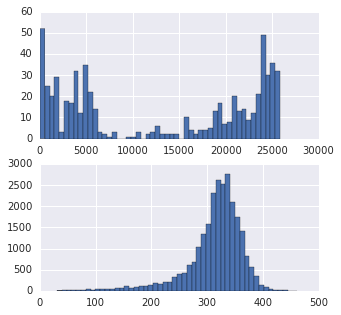

In [1172]:
%%time
counts = BES_numerics_only[BES_num_and_cat["wave9"]==1 ].count()
counts_by_individuals = BES_numerics_only[BES_num_and_cat["wave9"]==1 ].count(axis=1) # lets see
f, axarr = plt.subplots( 2 ,figsize=(5, 5) )
axarr[0].hist(counts,bins=50)
axarr[1].hist(counts_by_individuals,bins=50)

In [1173]:
# Suspicious answer coverage patterns
# (1) people who don't answer much (hence positive correlation with people answering 'polAttention               0.485386')
# (2) people who answer *too much* (hence positive correlation with 'EUContactLeaveSNP')

# suggests a strategy to try to fish out those people by including dumb questions to find people who've stopped paying attention

In [151]:
W9_vars = [x for x in BES_numerics_only.columns if "W9" in x]


In [1174]:
# BES_numerics_only.drop(W9_vars, axis=1, inplace=True)


In [1224]:
# drop people who are coverage outliers
# say top and bottom 5%
# BES_red = BES_numerics_only.loc[BES_reduced["wave9"]==1 ].copy()
BES_red = BES_numerics_only.copy()
BES_red["coverage"] = BES_numerics_only.count(axis=1)/BES_numerics_only.shape[1]

In [41]:
# BES_red["coverage"].loc[inlier_people].hist()

In [42]:
# BES_red["coverage"].quantile(1-thresh)
# BES_red["coverage"].quantile(  thresh)

In [1244]:
thresh = .00
outlier_people = BES_red[( BES_red["coverage"]>BES_red["coverage"].quantile(1-thresh) ) | 
                         ( BES_red["coverage"]<BES_red["coverage"].quantile(  thresh) ) ].index
inlier_people  = BES_red[( BES_red["coverage"]<BES_red["coverage"].quantile(1-thresh) ) & 
                         ( BES_red["coverage"]>BES_red["coverage"].quantile(  thresh) ) ].index

(array([  6.00000000e+00,   2.00000000e+01,   2.10000000e+01,
          2.70000000e+01,   2.40000000e+01,   4.00000000e+01,
          5.50000000e+01,   4.20000000e+01,   3.90000000e+01,
          8.30000000e+01,   7.50000000e+01,   7.30000000e+01,
          1.06000000e+02,   1.33000000e+02,   1.37000000e+02,
          1.98000000e+02,   2.08000000e+02,   2.16000000e+02,
          3.63000000e+02,   5.37000000e+02,   7.23000000e+02,
          5.48000000e+02,   6.60000000e+02,   8.06000000e+02,
          9.97000000e+02,   8.37000000e+02,   9.55000000e+02,
          6.97000000e+02,   7.69000000e+02,   9.54000000e+02,
          1.22800000e+03,   1.59900000e+03,   1.84700000e+03,
          2.55200000e+03,   2.71400000e+03,   2.58400000e+03,
          2.53900000e+03,   1.99600000e+03,   1.47400000e+03,
          1.01500000e+03,   6.22000000e+02,   4.51000000e+02,
          1.99000000e+02,   1.10000000e+02,   6.50000000e+01,
          3.00000000e+01,   1.80000000e+01,   8.00000000e+00,
        

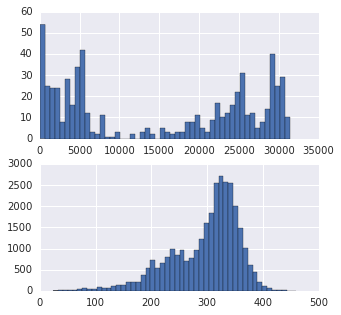

In [1245]:
counts = BES_numerics_only.loc[inlier_people].count() # super slow!
counts_by_individuals = BES_numerics_only.loc[inlier_people].count(axis=1) # lets see
f, axarr = plt.subplots( 2 ,figsize=(5, 5) )
axarr[0].hist(counts,bins=50)
axarr[1].hist(counts_by_individuals,bins=50)

In [1246]:
thresh = 0.11
mostly_filled_out = counts[counts> (counts.max()*thresh)].index

In [1]:
counts = BES_numerics_only.loc[inlier_people][mostly_filled_out].count() # super slow!
counts_by_individuals = BES_numerics_only.loc[inlier_people][mostly_filled_out].count(axis=1) # lets see
f, axarr = plt.subplots( 2 ,figsize=(5, 5) )
axarr[0].hist(counts,bins=20)
axarr[1].hist(counts_by_individuals,bins=20)

In [1229]:
# BES_min = BES_numerics_only.loc[inlier_people][mostly_filled_out]
BES_min = BES_numerics_only.loc[inlier_people][mostly_filled_out]

In [1209]:
# counts_by_individuals = BES_numerics_only[BES_reduced["wave9"]==1 ].loc[inlier_people][mostly_filled_out].count(axis=1)


In [1230]:
BES_min.isnull().sum().sum()/(BES_min.shape[0]*BES_min.shape[1])

0.5224679058071413

In [1231]:
BES_min.shape

(31407, 622)

In [1232]:
#[inlier_people]
# [mostly_filled_out]
# mostly_filled_out

In [515]:
# BES_latest = pd.read_stata("../BES_analysis_data/BES2015_W8_v1.6.dta") 

('euRefVote', 'euRefVotePost', 1.0, 0.92539879644665202, 0.1250676600757793, 0.1250676600757793)
('partyContactPC_4', 'partyContactCon_7', 1.0, 0.0045531250995001112, 0.041997007036647882, 0.0045531250995001112)
('partyContactPC_4', 'partyContactLD_4', 1.0, 0.0045531250995001112, 0.024039226923934155, 0.0045531250995001112)
('partyContactPC_7', 'partyContactCon_7', 1.0, 0.0045531250995001112, 0.041997007036647882, 0.0045531250995001112)
('partyContactPC_7', 'partyContactLD_4', 1.0, 0.0045531250995001112, 0.024039226923934155, 0.0045531250995001112)
('partyContactUKIP_3', 'partyContactLD_3', 1.0, 0.025408348457350273, 0.024039226923934155, 0.024039226923934155)
('partyContactGreen_2', 'partyContactPC_2', 1.0, 0.010952972267328939, 0.0045531250995001112, 0.0045531250995001112)
('partyContactGreen_3', 'partyContactUKIP_3', 1.0, 0.010952972267328939, 0.025408348457350273, 0.010952972267328939)
('partyContactOther_2', 'partyContactUKIP_2', 1.0, 0.0014646416403986371, 0.025408348457350273, 0

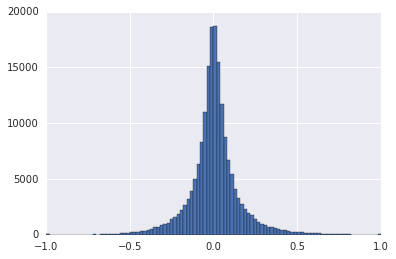

In [1233]:
corr_mat = BES_min.corr()
# create lower triangle - diag mask
col_vars = len( corr_mat )
df = pd.DataFrame( np.arange(col_vars*col_vars).reshape(col_vars,col_vars) )
mask = np.ones(df.shape,dtype='bool')
mask[np.triu_indices(len(df))] = False
corr_mat.mask(~mask).stack().hist(bins=100)

min_corr = []

thresh = .05
x = ( ( corr_mat>(1-thresh) ) &mask ).values.nonzero()
# z = list( zip(corr_mat.columns[x[0]],corr_mat.columns[x[1]]) )
# z
for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    c = BES_min[a].notnull().mean()
    d = BES_min[b].notnull().mean()
    print( ( a,b,corr_mat[a][b], c, d, min(c,d) ) )
    min_corr.append( min(c,d) )

x = ( ( corr_mat<(thresh-1) ) &mask ).values.nonzero()
# z = list( zip(corr_mat.columns[x[0]],corr_mat.columns[x[1]]) )
# z
for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    c = BES_min[a].notnull().mean()
    d = BES_min[b].notnull().mean()
    print( ( a,b,corr_mat[a][b], c, d, min(c,d) ) )
    min_corr.append( min(c,d) )

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000006CA0E320>]], dtype=object)

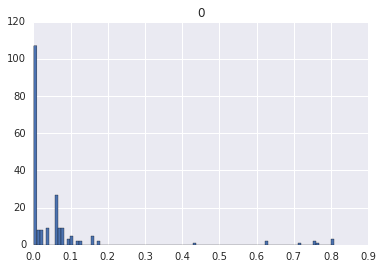

In [1234]:
pd.DataFrame(min_corr).hist(bins=100)

In [517]:
# without categories
high_corr_drop_list = ['euRefVoteUnsqueeze', 'euRefVote2', 'ageGroup', 'age', 'voted2015' ]

# with categories
# high_corr_drop_list = ['euRefVoteUnsqueeze', 'euRefVote2', 'ageGroup', 'age', 'voted2015', "ns_sec" , 'recallVote15']


# ns_sec/ns_sec_analytic ... hard to choose between
# BES_min.drop(high_corr_drop_list,axis=1, inplace=True)

In [ ]:
# BES_numerics_only.drop(W9_vars, axis=1, inplace=True)

In [56]:
# Age - age as of January 2014


In [57]:
# skip!
# BES_min = BES_numerics_only[BES_reduced["wave9"]==1 ]

In [1235]:
opts_per_cat = BES_min.apply(lambda x: len(pd.unique(x.dropna()))).sort_values()
# opts_per_cat

partyContactLab_5                     2
partyContactUKIP_5                    2
partyContactUKIP_4                    2
partyContactUKIP_3                    2
partyContactUKIP_2                    2
partyContactUKIP_1                    2
partyContactPC_7                      2
partyContactUKIP_6                    2
partyContactPC_6                      2
partyContactPC_4                      2
partyContactPC_3                      2
partyContactPC_2                      2
partyContactPC_1                      2
partyContactLD_7                      2
partyContactLD_6                      2
partyContactPC_5                      2
partyContactLD_5                      2
partyContactUKIP_7                    2
partyContactGreen_2                   2
EUContactRemainLab                    2
EUContactRemainCon                    2
partyContactOther_7                   2
partyContactOther_6                   2
partyContactOther_5                   2
partyContactOther_4                   2


In [1236]:
# BES_num_and_cat[opts_per_cat[opts_per_cat==2].index].dtypes # yes - all categories
two_opt_cats = opts_per_cat[opts_per_cat==2].index
# two_opt_cats

Index(['partyContactLab_5', 'partyContactUKIP_5', 'partyContactUKIP_4',
       'partyContactUKIP_3', 'partyContactUKIP_2', 'partyContactUKIP_1',
       'partyContactPC_7', 'partyContactUKIP_6', 'partyContactPC_6',
       'partyContactPC_4',
       ...
       'ldPriorities_nhsW9', 'selfOccStatus', 'euRefVoteSqueeze', 'euRefVote',
       'selfOccStatusLast', 'postalTurnout', 'euRefVotePost',
       'welshTurnoutRetro', 'postalapply', 'otherCitizen'],
      dtype='object', length=217)

In [1237]:
many_cat_drop_list = ['profile_lea', 'profile_oslaua', 'EUMIICategory']

In [521]:
# BES_min.drop(many_cat_drop_list,axis=1, inplace=True)

In [1238]:
BES_min.to_hdf(BES_data_folder+"BESW8min.hdf", "BESW8min")

In [1239]:
BES_min.shape

(31407, 622)

In [109]:
# BES_Panel.columns[(var_type["type"]==3)]

In [143]:
BES_new = pd.read_hdf(BES_data_folder+"BESW8min.hdf")


In [145]:
gc.collect()

0

In [1241]:
from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, MICE

In [177]:
# def create_rank_k_dataset(
#         n_rows=5,
#         n_cols=5,
#         k=3,
#         fraction_missing=0.1,
#         symmetric=False,
#         random_seed=0):
#     np.random.seed(random_seed)
#     x = np.random.randn(n_rows, k)
#     y = np.random.randn(k, n_cols)

#     XY = np.dot(x, y)

#     if symmetric:
#         assert n_rows == n_cols
#         XY = 0.5 * XY + 0.5 * XY.T

#     missing_raw_values = np.random.uniform(0, 1, (n_rows, n_cols))
#     missing_mask = missing_raw_values < fraction_missing

#     XY_incomplete = XY.copy()
#     # fill missing entries with NaN
#     XY_incomplete[missing_mask] = np.nan

#     return XY, XY_incomplete, missing_mask


# # create some default data to be shared across tests
# XY, XY_incomplete, missing_mask = create_rank_k_dataset(
#     n_rows=500,
#     n_cols=10,
#     k=3,
#     fraction_missing=0.25)

In [24]:
%%time
mice = MICE() # 1hr+ ->  2h 7min 43s
X_filled_mice = mice.complete( BES_new.values )
BESW8mice = pd.DataFrame( X_filled_mice, columns = BES_new.columns )
BESW8mice.to_hdf( BES_data_folder+"BESW8mice.hdf", "BESW8mice" )

In [ ]:
%%time
X_filled_knn = KNN(k=3).complete(BES_new) # 20 mins+
BESW8knn = pd.DataFrame( X_filled_knn, columns = BES_new.columns)
BESW8knn.to_hdf(BES_data_folder+"BESW8knn.hdf", "BESW8knn")

In [ ]:
# BES_new.to_stata(BES_data_folder+"BES_new.dta")

In [ ]:
# fancyimput MICE
# This version assumes all of the columns are ordinal,
#     and uses ridge regression

In [ ]:
# mice = MICE(n_imputations=3, impute_type='col')
# mice = MICE(n_imputations=1, n_burn_in=1, impute_type='pmm')
#XY_completed = mice.complete(XY_incomplete)

In [134]:
# %%time
# from fancyimpute import NuclearNormMinimization
# X_filled_nnm = NuclearNormMinimization().complete(BES_new)
# ran out of memory

In [136]:
# %%time
# from fancyimpute import SimilarityWeightedAveraging
# solver = SimilarityWeightedAveraging()
# X_filled_simwa = solver.complete(BES_new)
# TypeError: ufunc 'isfinite' not supported for the input types,
# and the inputs could not be safely coerced to any supported types
# according to the casting rule ''safe''

In [ ]:
# %%time
# from fancyimpute import MatrixFactorization
# solver = MatrixFactorization(
#     rank=3,
#     l1_penalty=0,
#     l2_penalty=0)
# XY_completed = solver.complete(BES_new)
# Took about an hour, websocket crashed

In [5]:
import gc
gc.collect()

27

In [ ]:
%%time
X_filled_softimpute = SoftImpute().complete(BES_new) # 40s
BESW8softimpute = pd.DataFrame( X_filled_softimpute, columns = BES_new.columns)
BESW8softimpute.to_hdf(BES_data_folder+"BESW8softimpute.hdf","BESW8softimpute")

In [ ]:
X_filled_median = BES_new.fillna(BES_new.median()).values
BESW8median = pd.DataFrame( X_filled_median, columns = BES_new.columns)
BESW8median.to_hdf(BES_data_folder+"BESW8median.hdf", "BESW8median")

X_filled_mean = BES_new.fillna(BES_new.mean()).values
BESW8mean = pd.DataFrame( X_filled_mean, columns = BES_new.columns)
BESW8mean.to_hdf(BES_data_folder+"BESW8mean.hdf", "BESW8mean")

In [ ]:
# DUMMY VARIABLES

In [16]:
# BESW8mice
# BES_imputed = BESW8median.copy()
BESW8mice = pd.read_hdf( BES_data_folder+"BESW8mice.hdf", "BESW8mice" )
BES_imputed = BESW8mice.copy()

In [17]:
dummy_list = BES_num_and_cat.columns[(var_type["type"]==3)]
dummy_list = list( set(dummy_list).intersection( BES_new.columns ) )
dummy_cats = BES_imputed.columns[ len(BES_imputed.columns)-len(dummy_list): ]

NameError: name 'BES_num_and_cat' is not defined

In [153]:
dummy_list = list( set(dummy_list).difference( W9_vars ) )
# temporary hack to remove EUMIICategory
# dummy_list.remove("EUMIICategory")
# BES_imputed.drop("EUMIICategory",axis=1, inplace=True)

In [154]:
for col in dummy_list:
    cats = BES_num_and_cat[col].cat.categories
    BES_imputed[col] = BES_imputed[col].astype('int').apply( lambda x: cats[x] )

KeyError: 'country_of_residence1'

In [1080]:
# add dummy rows to discrete imputed dataframe

BES_imputed = pd.get_dummies( BES_imputed, columns=dummy_list )
# convert dummy_list vars back to categorical!
# So they'll get new auto-labelled variables with meaningful names!
# BES_imputed.columns


In [1081]:
# two_opt_cats
# turn these columns -> int -> categorical
# but drop_first = True
for col in two_opt_cats:
    cats = BES_num_and_cat[col].cat.categories
    BES_imputed[col] = BES_imputed[col]\
        .astype('int').apply( lambda x: cats[x] ).astype('category').cat.reorder_categories(cats)

In [1082]:
BES_imputed = pd.get_dummies( BES_imputed, columns=two_opt_cats, drop_first=True )

In [1083]:
# * rename other variables with top category
# i.e. "blackEquality" -> "blackEquality_Gone much too far"

ordinal_list = BES_num_and_cat.columns[ (var_type["type"]==1)|(var_type["type"]==2)|(var_type["type"]==5) ]

In [1084]:
for ordinal in ordinal_list:
    new_col_name = ordinal + "__" + BES_num_and_cat[ordinal].cat.categories[-1:][0]
    BES_imputed.rename(columns={ordinal:new_col_name}, inplace=True)
#     BES_imputed[ordinal].cat.rename( print(  ) )

('country_Scotland', 'gor_Scotland', 1.0, 1.0, 1.0)
('country_Wales', 'gor_Wales', 1.0, 1.0, 1.0)
('polKnowMay_Leader of the Labour Party', 'polKnowMay_Home secretary', -0.96807446154228893, 1.0, 1.0)
('polKnowBercow_Speaker of the House of Commons', 'polKnowBercow_Home secretary', -0.98737861539829175, 1.0, 1.0)
('polKnowMiliband_Leader of the Labour Party', 'polKnowMiliband_Deputy Prime Minister', -0.98973296376211384, 1.0, 1.0)


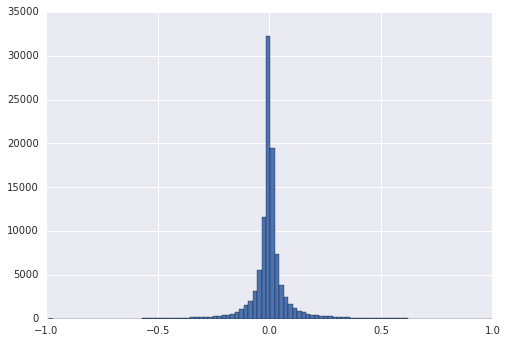

In [1085]:
## TEST CORRELATIONS
corr_mat = BES_imputed.corr()
# create lower triangle - diag mask
col_vars = len( corr_mat )
df = pd.DataFrame( np.arange(col_vars*col_vars).reshape(col_vars,col_vars) )
mask = np.ones(df.shape,dtype='bool')
mask[np.triu_indices(len(df))] = False
corr_mat.mask(~mask).stack().hist(bins=100)

thresh = .05
x = ( ( corr_mat>(1-thresh) ) &mask ).values.nonzero()
# z = list( zip(corr_mat.columns[x[0]],corr_mat.columns[x[1]]) )
# z
for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    print( ( a,b,corr_mat[a][b], BES_imputed[a].notnull().mean(), BES_imputed[b].notnull().mean() ) )

x = ( ( corr_mat<(thresh-1) ) &mask ).values.nonzero()
# z = list( zip(corr_mat.columns[x[0]],corr_mat.columns[x[1]]) )
# z
for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    print( ( a,b,corr_mat[a][b], BES_imputed[a].notnull().mean(), BES_imputed[b].notnull().mean() ) )    

In [1086]:
high_corr_drop_list = ['country_Scotland', 'country_Wales', 'polKnowMay_Leader of the Labour Party',
                       'polKnowBercow_Home secretary', 'polKnowMiliband_Deputy Prime Minister']

BES_imputed.drop(high_corr_drop_list,axis=1, inplace=True)

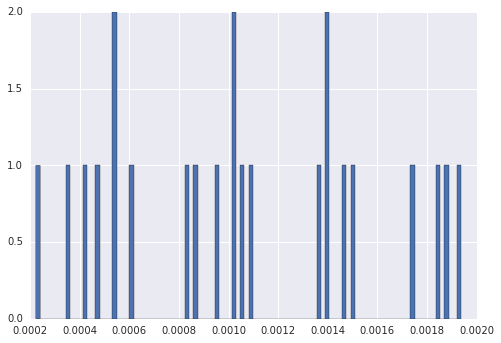

In [1087]:
## TEST VARIANCES
a = BES_imputed.var()
b = a<a.quantile(.05)
a[b].hist(bins=100)
very_low_var = BES_imputed.columns[b]
# a.quantile(.01)

In [1088]:
# very_low_var
NoiseVariance.loc[very_low_var].sort_values(by='noise_variance_')

# upshot - get rid of 

noise_variance_
profile_religion_Yes - Sikhism                             0.644013
profile_religion_denom_Sikh                                0.647026
profile_religion_denom_Hindu                               0.672180
profile_religion_denom_Buddhist                            0.783184
profile_religion_Yes - Brethren                            0.806162
profile_religion_denom_Brethren                            0.814896
profile_ethnicity_Bangladeshi                              0.847467
profile_past_vote_2005_Respect                             0.860562
profile_past_vote_2010_Respect                             0.864729
polKnowClegg_Home secretary                                0.879120
profile_religion_Yes - Free Presbyterian                   0.890822
polKnowMiliband_Home secretary                             0.891029
polKnowBercow_Deputy Prime Minister                        0.891728
profile_religion_denom_Free Presbyterian                   0.897373
polKnowBercow_Leader of the Labour Party                   0.899533
polKnowOsborne_Speaker of the House of Commons             0.902952
polKnowClegg_Speaker of the House of Commons               0.913941
polKnowMiliband_Speaker of the House of Commons            0.917800
profile_ethnicity_Any other Asian background               0.932101
profile_ethnicity_White and Black African                  0.943976
profile_past_vote_2015_British National Party (...         0.950042
profile_ethnicity_Any other black background               0.961116
profile_past_vote_2005_Veritas                             0.966350

In [1090]:
# if fancyimpute not installed....
#



In [1091]:
# dummy variables!

In [1126]:
import gc
gc.collect()

0

In [1093]:
# BES_std = BES_std[ [x for x in BES_std.columns if "immig" in x] ]
# BES_std = BES_std[["al1","al2","al3","al4","al5","lr1","lr2","lr3","lr4","lr5"]]

In [1094]:
# PCA explained variance ratios
# With non-ordinal categories and inliers=0. mostly filled out=.33, W9 variables removed
# median:   [ 0.14313333  0.0403353   0.03491838  0.01973895  0.01817465] -> discrete
# mean:     [ 0.14375354  0.04159885  0.03735017  0.02004535  0.01795147]
# soft_imp: [ 0.15555434  0.04600371  0.04434897  0.02558684  0.01890025]
# knn:      [ 0.1538535   0.0446753   0.04336145  0.02204251  0.01843298]
# mice:     [ 0.14867557  0.04312989  0.04052034  0.02073704  0.01762334] -> discrete
# n=100     [ 0.1567385   0.04616502  0.04503352  0.02257613  0.01889345]

In [6]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [7]:
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA

# IncrementalPCA()   # batchPCA for when you hit memory problems
# KernelPCA()        # PCA with an initial transform
# TruncatedSVD       # doesn't rely on centering matrix - good for sparse matrices like tf/idf Shit!
# ProjectedGradientNMF  # non-negative matrix factorisation
           # output from putting non-centered matrix in, 7mins and shit!
# DictionaryLearning -> too slow
# MiniBatchSparsePCA() 
# manifold.MDS -> memory error


# PCA
# FastICA()          # doesn't find axes of variance, finds 'independent components' as if signal mixed
# FactorAnalysis()   #
# SparsePCA()        # Sparse PCA tries to return components with onyl a few var each works if you jack up alpha



In [1096]:
# pca
# 'auto' 1.43133329e-01   4.03353025e-02   3.49183792e-02   1.97389845e-02
# 'full' 1.43133329e-01   4.03353025e-02   3.49183792e-02   1.97389845e-02
#       0.14313333     0.0403353         0.03491838       0.01973898  # (n_components=230,svd_solver='arpack')
#       0.14313333  0.0403353   0.03491838  0.01973898   # (n_components=10,svd_solver='arpack')
#        1.43133329e-01   4.03353025e-02   3.49183792e-02   1.97389845e-02 # 'randomized'
#       1.43133329e-01   4.03353025e-02   3.49183792e-02   1.97389845e-02 (svd_solver='full', n_components='mle',whiten=True)

# PCA(svd_solver='full', n_components=.2,whiten=True)
# 3 comp [ 0.14313333  0.0403353   0.03491838], [ 34.20886568   9.64013729   8.34549263], 0.791548747452, -318.005463144
# TruncatedSVD(n_components=3)
# 3 comp [ 0.14313333  0.0403353   0.03491836], [ 34.20886568   9.64013714   8.3454873 ], IDENTICAL
# FastICA(algorithm='deflation', fun='exp', fun_args=None, max_iter=1000, tol=0.07,  whiten=False)
# Something here - but slow and fiddly and very noisy!
# FactorAnalysis(svd_method = 'lapack')
# Best output so far!
# SparsePCA(n_components=30, alpha=20,max_iter=1000,n_jobs=4,tol=1e-10, verbose=True)
# Slow ~ 10 mins - sparsity forces break up of components - euRefVote/al-scale


In [1097]:
# BES_imputed = BES_imputed.loc[pd.Index(Leave_Remain_inds).intersection( BES_imputed.index )]


In [8]:
# PCA

#fulldata_withPP - all samples, no columns removed due to NAs, preprocessing for weasel answers
Treatment = "fulldata_withPP/"
if not os.path.exists(BES_data_folder+Treatment):
    os.makedirs(BES_data_folder+Treatment)



In [1099]:
%%time
# X_filled_softimpute
# BES_imputed.drop(dummy_cats,axis=1,inplace=True, errors='ignore')
clean_feature_set_std = StandardScaler().fit_transform(BES_imputed.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES_imputed.columns,
                             index   = BES_imputed.index      )
# drop non-ordinal categorical variables
#BES_std = BES_std.drop(cats,axis=1,errors ='ignore')

#n_components=5

# (svd_solver='full', n_components='mle',whiten=True)



decomp = PCA(svd_solver='full', whiten=False)
decomp = FastICA(algorithm='deflation', fun='exp', fun_args=None, max_iter=1000,
    n_components=None, random_state=None, tol=0.07, w_init=None, whiten=False) # 2h 1min 4s "fast"

#decomp = SparsePCA(n_components=30, alpha=20,max_iter=1000,n_jobs=4,tol=1e-10, verbose=True) # 5min
decomp = FactorAnalysis(svd_method = 'lapack') ## ~10s ,n_components=20 -> makes it slow!


X_r = decomp.fit_transform(BES_std)
n_components = decomp.components_.shape[0]
BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_imputed.index)




Wall time: 13.6 s


In [9]:
# SAVE decomp results
suff = str(decomp).split("(")[0]
# fname = "../BES_analysis_data/"+suff+".pkl"
# with open(fname, "wb") as f:
#     pickle.dump( (decomp,BES_decomp), f )

fname = BES_data_folder+Treatment+suff+".pkl"
with open(fname, "wb") as f:
    pickle.dump( decomp, f )
    
fname = BES_data_folder+Treatment+suff+".hdf"
BES_decomp.to_hdf(fname,suff)
# with open(fname, "wb") as f:
#     pickle.dump( (decomp,BES_decomp), f )


NameError: name 'decomp' is not defined

In [10]:
# LOAD decomp results
# fname = "../BES_analysis_data/"+"FastICA"+".pkl"
# with open(fname, "rb") as f:
#     a,b = pickle.load(f) 
# suff = str(decomp).split("(")[0]
Treatment = "fulldata_withPP/"
suff = "FactorAnalysis"

fname = BES_data_folder+Treatment+suff+".pkl"
with open(fname, "rb") as f:
    decomp = pickle.load(f) 
    
fname = BES_data_folder+Treatment+suff+".hdf"
BES_decomp = pd.read_hdf(fname)

n_components = decomp.components_.shape[0]

In [11]:

decomp

FactorAnalysis(copy=True, iterated_power=3, max_iter=1000, n_components=None,
        noise_variance_init=None, random_state=0, svd_method='lapack',
        tol=0.01)

In [12]:
figsz = (3,3)

if hasattr(decomp, 'explained_variance_ratio_'):
    print('explained variance ratio: %s'
          % str(decomp.explained_variance_ratio_) )
    
if hasattr(decomp, 'explained_variance_'):
    print('explained variance: %s'
          % str(decomp.explained_variance_) )
    plt.figure(figsize = figsz)
    plt.plot( range(1,n_components+1), decomp.explained_variance_, linewidth=2)
    plt.xlabel('n_components')
    plt.ylabel('explained_variance_') 
    
if hasattr(decomp, 'noise_variance_'): 
    if (len(decomp.noise_variance_)==1):
        print('noise variance: %s'
              % str(decomp.noise_variance_) )
    
if hasattr(decomp, 'score'):
    print('average log-likelihood of all samples: %s'
          % str(decomp.score(BES_std)) )
    
if hasattr(decomp, 'score_samples'):
    pd.DataFrame( decomp.score_samples(BES_std) ).hist(bins=100,figsize = figsz)

if hasattr(decomp, 'n_iter_'):
    print('number of iterations: %s'
          % str(decomp.n_iter_) )
    
if hasattr(decomp, 'loglike_'):
    plt.figure(figsize = figsz)
    plt.plot( decomp.loglike_, linewidth=2 )
    plt.xlabel('n_iter')
    plt.ylabel('log likelihood') 

if hasattr(decomp, 'error_'):
    plt.figure(figsize = figsz)
    plt.plot( decomp.error_, linewidth=2)
    plt.xlabel('n_iter')
    plt.ylabel('error') 

NameError: name 'BES_std' is not defined

In [1104]:
# decomp_label_col = 'euRefVote'
# decomp_label_categories = list(BES_num_and_cat[decomp_label_col].cat.categories)
# # ['Stay/remain in the EU', 'Leave the EU']
# plt.figure()
# cat = 'Leave the EU'
# cat_entries = BES_num_and_cat[BES_num_and_cat[decomp_label_col]==cat].index.intersection( BES_std.index )
# BES_decomp.loc[ cat_entries, 0 ].hist(bins=100)
# plt.figure()
# cat = 'Stay/remain in the EU'
# cat_entries = BES_num_and_cat[BES_num_and_cat[decomp_label_col]==cat].index.intersection( BES_std.index )
# BES_decomp.loc[ cat_entries, 0 ].hist(bins=100)

In [1]:
# BES_imputed["euRefVote_Leave the EU"].corr( BES_decomp.loc[ :, 0 ] )

#BES_imputed["euRefVote_Leave the EU"].corr( BES_imputed["al2"] )
# calls for density mapping!

In [1106]:
# plt.figure(figsize=(20,20))

# decomp_label_col = 'euRefVote'
# # BES_num_and_cat[decomp_label_col].cat.categories

# colours = cycle('brycmkg')
# markers = cycle(',oD*x+v^<>')


# decomp_label_categories = list(BES_num_and_cat[decomp_label_col].cat.categories)
# # drop cat
# # 'No party is best able to handle this issue'
# drop_cat = ''

# if drop_cat in decomp_label_categories:
#     decomp_label_categories.remove(drop_cat)
# #for k, col in zip(range(n_clusters_), colors)
# # for non-ordinal categorical

# for cat, col, mar in zip(decomp_label_categories, colours, markers):
#     cat_entries = BES_num_and_cat[BES_num_and_cat[decomp_label_col]==cat].index.intersection( BES_std.index )
#     plt.scatter(BES_decomp.loc[ cat_entries, 0 ],
#                 BES_decomp.loc[ cat_entries, 1 ],
#                 c= col,
#                 marker=mar,
#                 label=cat,
#                 edgecolors=col,
#                 alpha = .9 )
    
    
# # plt.scatter( X_r[ np.ix_(Stay , [0]) ] , X_r[ np.ix_(Stay , [1]) ], c='b', label="Stay"  )
# # plt.scatter( X_r[:,0 ] , X_r[:, 1 ], c='b'  )

# plt.legend()
# plt.title('Decomposition of BES dataset; labelled variable: ' + decomp_label_col)
# plt.show()

In [14]:
# [ x for x in BES_imputed.columns if "al_scale" in x ]

In [15]:
# for ordinal categorical
# winter, autumn
cmap_name = "winter"
fig = plt.figure( figsize=(16,10) )
decomp_label_col = 'lr_scale_Right'

plt.scatter(BES_decomp.loc[ :, 0 ],
            BES_decomp.loc[ :, 1 ],
            cmap = plt.get_cmap(cmap_name),
            c = BES_imputed[decomp_label_col].values,
            edgecolor = "None",
            alpha = 0.9) #            edgecolors=col,
plt.colorbar().set_label("Economic left =0, Economic right =20")
plt.title('Decomposition of BES dataset; labelled variable: ' + decomp_label_col)
plt.xlabel('Component: 0')
plt.ylabel('Component: 1') 
plt.show()

fig.savefig( BES_data_folder+Treatment+"lr_scale.png", bbox_inches='tight' )

NameError: name 'BES_imputed' is not defined

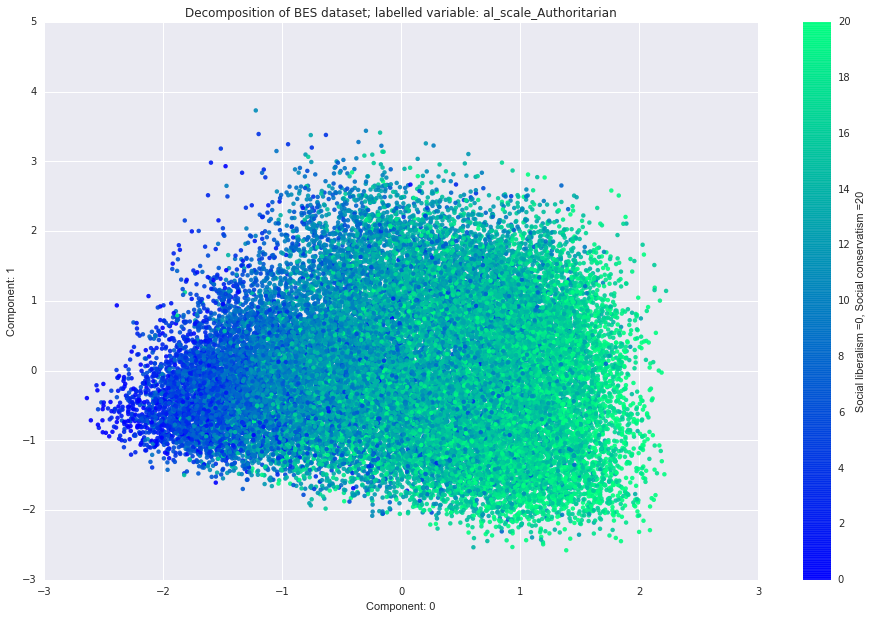

In [1109]:
# for ordinal categorical
# winter, autumn
cmap_name = "winter"
fig = plt.figure( figsize=(16,10) )
decomp_label_col = 'al_scale_Authoritarian'
plt.scatter(BES_decomp.loc[ :, 0 ],
            BES_decomp.loc[ :, 1 ],
            cmap = plt.get_cmap(cmap_name),
            c= BES_imputed[decomp_label_col].values,
            edgecolor = "None",
            alpha = .9) #            
plt.colorbar().set_label("Social liberalism =0, Social conservatism =20")
plt.title('Decomposition of BES dataset; labelled variable: ' + decomp_label_col)
plt.xlabel('Component: 0')
plt.ylabel('Component: 1') 
plt.show()

fig.savefig( BES_data_folder+Treatment+"al_scale.png", bbox_inches='tight' )

In [2]:
# SUPER USEFUL FOR FEATURE EXTRACTION/VARIABLE PREP!

if hasattr(decomp, 'noise_variance_'):
    if (len(decomp.noise_variance_)>1):
        NoiseVariance = pd.DataFrame( decomp.noise_variance_ , index = BES_std.columns, columns = ["noise_variance_"])
        NoiseVariance.hist( bins = int(len( NoiseVariance )/10) )
        NoiseVariance = NoiseVariance.sort_values(by="noise_variance_")
        display( NoiseVariance )


NameError: name 'decomp' is not defined

In [1111]:
NoiseVariance[ NoiseVariance["noise_variance_"]>.9 ].sort_index()

noise_variance_
euMIISmall_EU integration/stability                        0.912097
euMIISmall_Family                                          0.909600
profile_ethnicity_Any other black background               0.911699
profile_past_vote_2005_Veritas                             0.927413
profile_past_vote_2015_British National Party (...         0.900612

In [1112]:
# who are the "improbables"?

if hasattr(decomp, 'score_samples'):
    most_likely = pd.DataFrame(decomp.score_samples(BES_std)).quantile(.999).values[0]
    least_likely = pd.DataFrame(decomp.score_samples(BES_std)).quantile(.001).values[0]
    print("least likely")
    display(BES_num_and_cat.loc[ BES_imputed.index[decomp.score_samples(BES_std)<least_likely] ])
# who are the "stereotypes"?
    print("most likely")
    display(BES_num_and_cat.loc[ BES_imputed.index[decomp.score_samples(BES_std)>most_likely] ])
# check to see balance of missing values!

least likely


id  wt_core_W8  wt_core_W9  wt_full_W8  wt_full_W1W2W3W4W5W6W7  \
74       131    0.304217    0.319231    0.190794                     NaN   
1667    3041    1.035925         NaN    1.234997                1.108415   
2299    4168    1.447414    1.491808    2.125031                2.595312   
2819    5176         NaN         NaN    0.301643                0.187151   
3508    6321    1.861061    2.002256    3.084461                4.828419   
5081    9223    0.625764         NaN    0.551553                0.419515   
5276    9561         NaN    0.908128    0.938262                1.128004   
6605   11947         NaN    0.430852    0.488304                0.363224   
7064   12758    0.464327    0.449404    0.336574                     NaN   
7147   12908    0.736346    0.753043    0.709442                     NaN   
7303   13173    0.632526    0.592813    0.548159                0.481267   
9812   17873         NaN    0.497188    0.387614                0.220548   
10646  19456         NaN         NaN    0.104337                     NaN   
10718  19611         NaN    1.022951    1.099410                1.271387   
10830  19823         NaN         NaN    0.380927                     NaN   
11206  20544         NaN         NaN    0.679489                0.297809   
12373  22892         NaN    0.461077    0.434433                0.230801   
13189  24598    0.707372    0.771300    0.870351                0.819082   
13222  24680         NaN    0.300299    0.243674                     NaN   
13466  25249    1.930042    2.323516    2.790860                     NaN   
14155  27101         NaN    0.834796    0.809820                1.277334   
14806  29048         NaN         NaN    0.588855                0.570831   
15509  31342    0.362849         NaN    0.199810                     NaN   
16900  34923    0.584036         NaN    0.481155                     NaN   
17683  37671         NaN         NaN    0.116264                     NaN   
17817  38038    1.235364    1.258793    1.673539                     NaN   
17882  38151    0.535312    0.504302    0.430321                     NaN   
22645  46944    2.175640    2.183515    2.977579                     NaN   
27942  53793    0.569600         NaN    0.454665                     NaN   
29686  55661         NaN         NaN    0.510242                     NaN   
29874  55859    1.062497    1.070842    1.099582                     NaN   
30558  56591    0.474088         NaN    0.403758                     NaN   

       wt_full_W7  wt_full_W9  wt_full_W1W2W3W4W5W6W7W8W9  wt_full_W7W8W9  \
74            NaN    0.224187                         NaN             NaN   
1667     1.065572         NaN                         NaN             NaN   
2299     1.586258    2.107472                    2.573341        1.613712   
2819     0.327476    0.286690                    0.181907        0.302830   
3508     2.640366    3.169017                    5.544393        2.685891   
5081     0.703244    0.563440                    0.405883        0.674933   
5276     0.971715    0.953694                    1.239623        0.980463   
6605     0.479325    0.485923                    0.460025        0.487679   
7064          NaN    0.347890                         NaN             NaN   
7147     0.786559    0.707891                         NaN        0.767060   
7303     0.510586    0.516358                    0.453681        0.507767   
9812     0.443214    0.390342                    0.232615        0.426565   
10646    0.121481    0.103995                         NaN        0.118601   
10718    1.155930    1.094272                    1.379897        1.156971   
10830         NaN         NaN                         NaN             NaN   
11206    0.530379         NaN                         NaN             NaN   
12373    0.411100    0.403790                    0.207787        0.385576   
13189    0.794988    0.948840                    0.780313        0.779590   
13222         NaN    0.238468         

most likely


id  wt_core_W8  wt_core_W9  wt_full_W8  wt_full_W1W2W3W4W5W6W7  \
5385    9792         NaN    0.386009    0.377078                0.187734   
10865  19902         NaN    0.408330    0.395871                0.211490   
13389  25082    0.810791    0.876715    0.880591                0.541854   
14602  28341         NaN    0.282550    0.231088                     NaN   
16739  34605    0.926234         NaN    1.062169                     NaN   
18006  38364    1.111210         NaN    1.386460                     NaN   
18875  40326    0.747196    0.737678    0.702078                     NaN   
20621  44095    1.777157    1.893327    2.825212                     NaN   
21709  45665         NaN         NaN    0.290098                     NaN   
22623  46912    1.576645    1.741307    2.224013                     NaN   
23690  48398    0.609173    0.584759    0.529302                     NaN   
25762  51475    0.638782         NaN    0.559008                     NaN   
25804  51519    0.748690         NaN    0.714138                     NaN   
25890  51614    0.638606         NaN    0.551527                     NaN   
25952  51683         NaN    0.633110    0.551527                     NaN   
25956  51687    0.804148         NaN    0.861337                     NaN   
26249  51998    0.741090         NaN    0.686405                     NaN   
26375  52134    1.342535    1.334554    1.788302                     NaN   
26506  52274    1.157192         NaN    1.482262                     NaN   
26569  52343    1.190132         NaN    1.559607                     NaN   
26951  52751         NaN    0.501954    0.436749                     NaN   
27155  52963         NaN         NaN    0.909380                     NaN   
27774  53614    1.184252    1.314005    1.388623                     NaN   
28055  53910         NaN    0.592813    0.548159                     NaN   
28081  53939         NaN         NaN    0.095256                     NaN   
28712  54603         NaN    0.213520    0.091358                     NaN   
29210  55146         NaN    0.832995    0.805568                     NaN   
29780  55761    1.297204    1.396554    1.627021                     NaN   
30392  56412    1.677433    1.848794    2.577445                     NaN   
30420  56441    0.630048    0.634679    0.555833                     NaN   
30426  56447    1.081034    1.222847    1.620835                     NaN   
30914  56982         NaN    0.637886    0.551553                     NaN   

       wt_full_W7  wt_full_W9  wt_full_W1W2W3W4W5W6W7W8W9  wt_full_W7W8W9  \
5385     0.331401    0.398325                    0.189034        0.323497   
10865    0.354043    0.417249                    0.215751        0.356741   
13389    0.817514    1.044710                    0.555381        0.906126   
14602         NaN    0.232456                         NaN             NaN   
16739    0.939023    1.015161                         NaN        0.917967   
18006    1.281764         NaN                         NaN             NaN   
18875    0.752163    0.679403                         NaN        0.722327   
20621    2.877940    2.881629                         NaN        2.880877   
21709    0.364134         NaN                         NaN             NaN   
22623    2.657398    2.349928                         NaN        2.667457   
23690    0.504079    0.512318                         NaN        0.477617   
25762         NaN         NaN                         NaN             NaN   
25804         NaN         NaN                         NaN             NaN   
25890         NaN         NaN                         NaN             NaN   
25952         NaN    0.560326                         NaN             NaN   
25956         NaN         NaN                         NaN             NaN   
26249         NaN         NaN                         NaN             NaN   
26375         NaN    1.676087                         NaN             NaN   
26506         NaN    1.437947         

ValueError: Shape of passed values is (1, 452), indices imply (1, 31407)

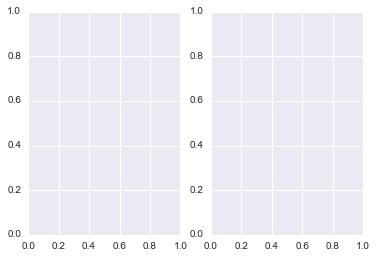

In [138]:
# %%time
n_comps = min(n_components,20)

for comp_no in range(0,n_comps):

    fig, axes = plt.subplots(ncols=2)
    
    ax = axes[1]
    comp = pd.DataFrame( decomp.components_[comp_no], index = BES_decomp.index, columns = ["components_"] )
    comp["comp_absmag"] = comp["components_"].abs()
    comp = comp.sort_values(by="comp_absmag",ascending=True)
    ax.set_xlabel("abs. variable coeffs")
    ax.set_title("Histogram of abs. variable coeffs")
    comp["comp_absmag"].hist( bins=30, ax=ax, figsize=(10,6) )

    # detect threshold

    ax = axes[0]
    ax.set_title("Component: "+str(comp_no))
    ax.set_xlabel("variable coeffs")
    comp["components_"].tail(30).plot( kind='barh', ax=ax,figsize=(10,6) )

    fig.savefig( BES_data_folder+Treatment+"Decomp_component "+str(comp_no)+".png", bbox_inches='tight' )
    
    if comp_no >2:
        plt.close()

In [140]:
decomp

FactorAnalysis(copy=True, iterated_power=3, max_iter=1000, n_components=None,
        noise_variance_init=None, random_state=0, svd_method='lapack',
        tol=0.01)

number of estimated clusters : 1


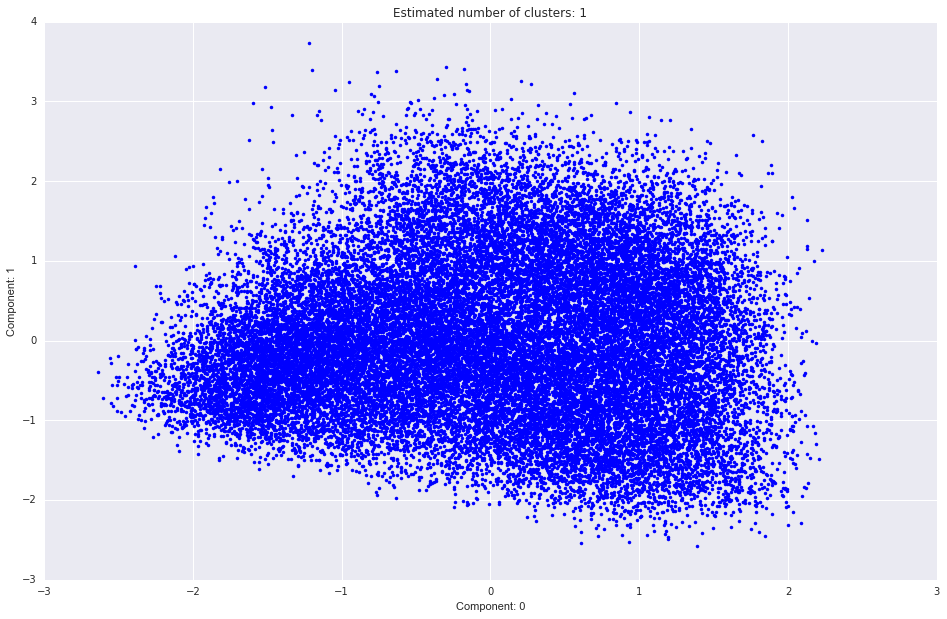

In [1114]:
# %%time
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs


X = X_r


# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)


fig = plt.figure( figsize=(16,10) )
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.xlabel('Component: 0')
plt.ylabel('Component: 1')   
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

fig.savefig(BES_data_folder+Treatment+"Cluster_estimation.png",bbox_inches='tight')


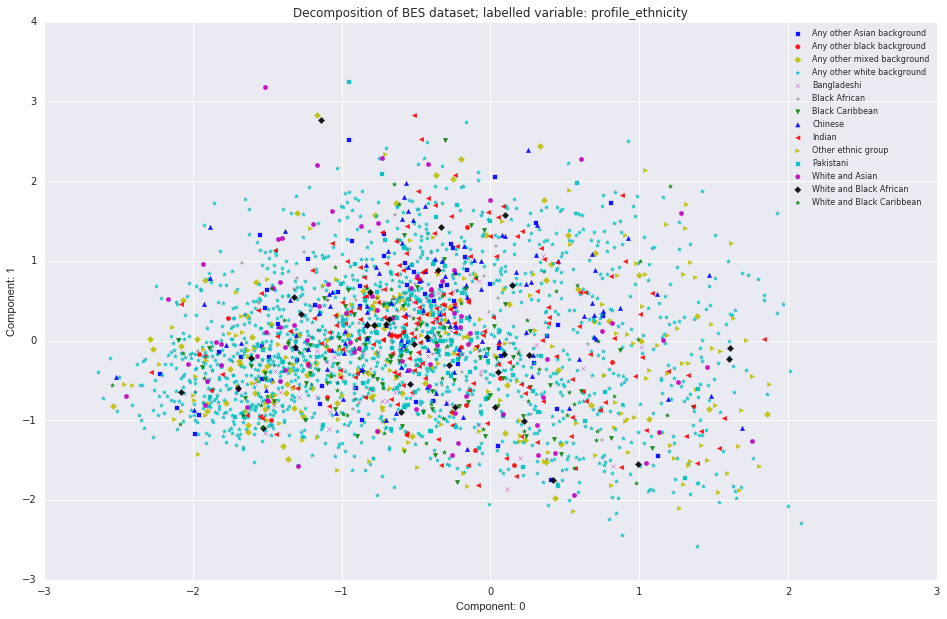

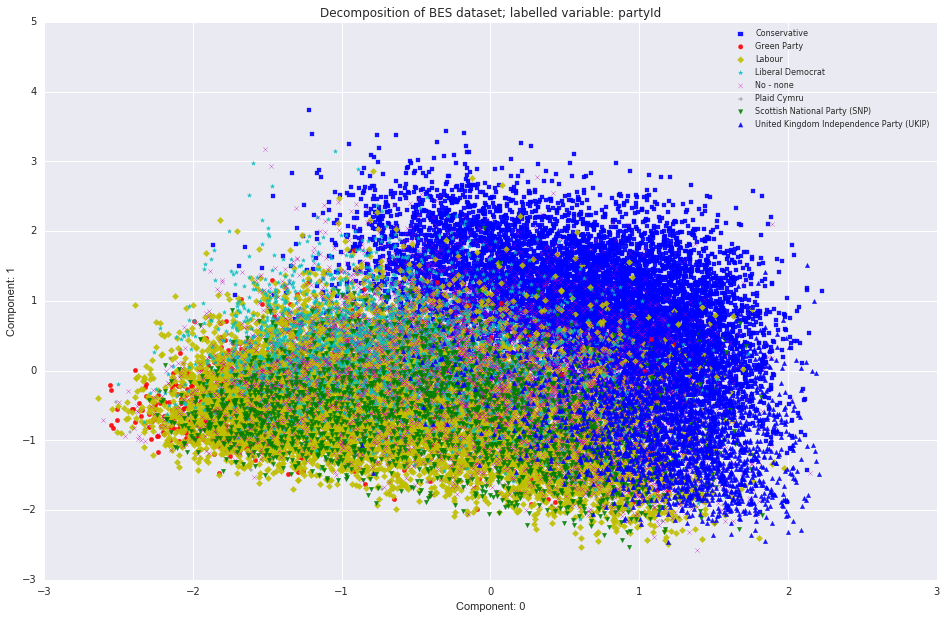

In [1131]:
fig_no = 0
for decomp_label_col in dummy_list:
    if decomp_label_col in ["profile_religion","country",
                            'polKnowMay','polKnowOsborne',
                            'polKnowClegg', 'polKnowBercow', 'polKnowMiliband',
                            'registered']:
        continue
    
    fig = plt.figure( figsize=(16,10) )

    colours = cycle('brycmkg')
    markers = cycle(',oD*x+v^<>')

    decomp_label_categories = [ x for x in BES_imputed.columns if (decomp_label_col + "_") in x ]

#     decomp_label_categories = list(BES_num_and_cat[decomp_label_col].cat.categories)
    # drop cat
    # 'No party is best able to handle this issue'
    drop_cat_list = ['profile_education_age', 'profile_ethnicity_White British']
    for drop_cat in drop_cat_list:
        if drop_cat in decomp_label_categories:
            decomp_label_categories.remove(drop_cat)


    for cat, col, mar in zip(decomp_label_categories, colours, markers):
        cat_entries = BES_imputed[cat]==1

        lab = re.search('_([^_]+)$',cat).groups()[0]

        plt.scatter(BES_decomp.loc[ cat_entries, 0 ],
                    BES_decomp.loc[ cat_entries, 1 ],
                    c= col,
                    marker=mar,
                    label=lab,
                    edgecolors=col,
                    alpha = .9 )
    
    plt.xlabel('Component: 0')
    plt.ylabel('Component: 1') 
    plt.legend(prop={'size':8})
    plt.title('Decomposition of BES dataset; labelled variable: ' + decomp_label_col)
#     plt.show()
    
    fig.savefig( BES_data_folder+Treatment+decomp_label_col, bbox_inches='tight' )
    if fig_no >1:
        plt.close()
    fig_no = fig_no + 1

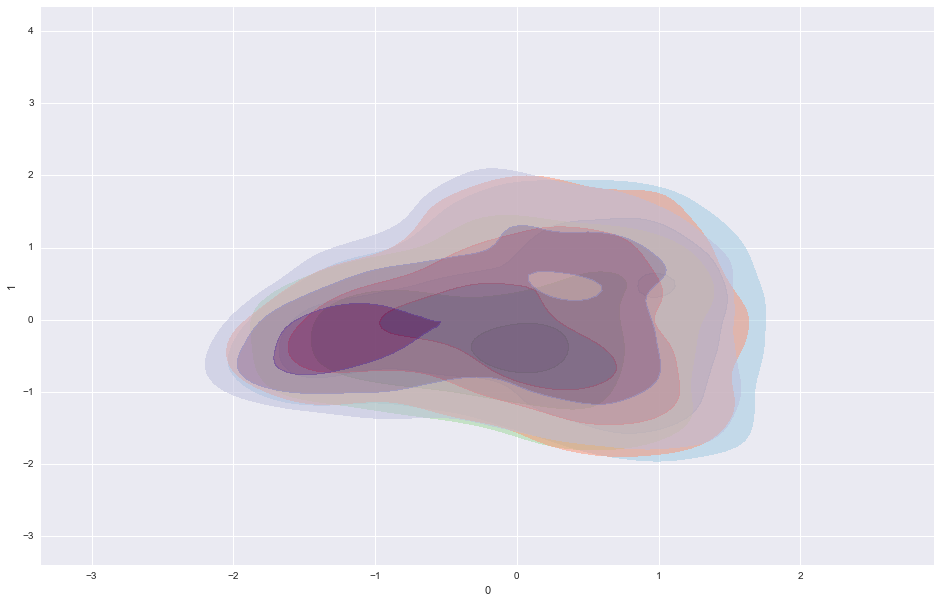

In [34]:
# ["Blues","Greens","Greys","Oranges","Purples","Reds"]
fig = plt.figure( figsize=(16,10) )
notvot_inds = Notvoters_inds.intersection( BES_imputed.index )
dk_inds      = Dontknow_inds.intersection( BES_imputed.index )
rem_inds       = Remain_inds.intersection( BES_imputed.index )
n_levels = 3
cm = LinearSegmentedColormap.from_list( 'mycmap', [(0, 'b'), (1 , 'b')] )
sns.kdeplot( BES_decomp[0].loc[Leave_inds],  BES_decomp[1].loc[Leave_inds],  cmap="Blues",shade=True,shade_lowest=False,n_levels=3, alpha=.5)
cm = LinearSegmentedColormap.from_list( 'mycmap', [(0, 'g'), (1 , 'g')] )
sns.kdeplot( BES_decomp[0].loc[notvot_inds], BES_decomp[1].loc[notvot_inds], cmap="Greens",shade=True,shade_lowest=False,n_levels=3, alpha=.5)
cm = LinearSegmentedColormap.from_list( 'mycmap', [(0, 'r'), (1 , 'r')] )
sns.kdeplot( BES_decomp[0].loc[dk_inds],     BES_decomp[1].loc[dk_inds],     cmap="Reds",shade=True,shade_lowest=False,n_levels=3, alpha=.5)
cm = LinearSegmentedColormap.from_list( 'mycmap', [(0, 'y'), (1 , 'y')] )
sns.kdeplot( BES_decomp[0].loc[rem_inds],    BES_decomp[1].loc[rem_inds],    cmap="Purples", shade=True,shade_lowest=False,n_levels=3, alpha=.5)
# sns.kdeplot( BES_decomp[0].loc[Remain_inds.intersection( BES_imputed.index )],
#             BES_decomp[1].loc[Remain_inds.intersection( BES_imputed.index )], cmap="autumn", n_levels=2)
# n_levels=6
#a = sns.kdeplot( BES_decomp[0], BES_decomp[1] , kwargs = {'colors':'r'})

In [1018]:
# ["Blues","Greens","Greys","Oranges","Purples","Reds"]
fig = plt.figure( figsize=(16,10) )
notvot_inds = Notvoters_inds.intersection( BES_imputed.index )
dk_inds      = Dontknow_inds.intersection( BES_imputed.index )
rem_inds       = Remain_inds.intersection( BES_imputed.index )
n_levels = 3
cm = LinearSegmentedColormap.from_list( 'mycmap', [(0, 'b'), (1 , 'b')] )
sns.kdeplot( BES_decomp[0].loc[Leave_inds],  BES_decomp[1].loc[Leave_inds],  cmap="Blues",shade=True,shade_lowest=False,n_levels=3)
cm = LinearSegmentedColormap.from_list( 'mycmap', [(0, 'g'), (1 , 'g')] )
sns.kdeplot( BES_decomp[0].loc[notvot_inds], BES_decomp[1].loc[notvot_inds], cmap="Greens",shade=True,shade_lowest=False,n_levels=3)
cm = LinearSegmentedColormap.from_list( 'mycmap', [(0, 'r'), (1 , 'r')] )
sns.kdeplot( BES_decomp[0].loc[dk_inds],     BES_decomp[1].loc[dk_inds],     cmap="Reds",shade=True,shade_lowest=False,n_levels=3)
cm = LinearSegmentedColormap.from_list( 'mycmap', [(0, 'y'), (1 , 'y')] )
sns.kdeplot( BES_decomp[0].loc[rem_inds],    BES_decomp[1].loc[rem_inds],    cmap="Purples", shade=True,shade_lowest=False,n_levels=3)
# sns.kdeplot( BES_decomp[0].loc[Remain_inds.intersection( BES_imputed.index )],
#             BES_decomp[1].loc[Remain_inds.intersection( BES_imputed.index )], cmap="autumn", n_levels=2)
# n_levels=6
#a = sns.kdeplot( BES_decomp[0], BES_decomp[1] , kwargs = {'colors':'r'})

AttributeError: 'JointGrid' object has no attribute 'jointplot'

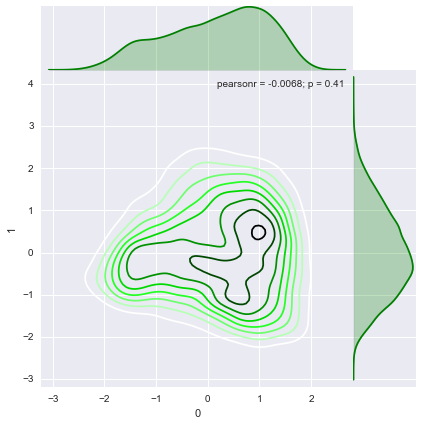

In [44]:
fig = plt.figure( figsize=(16,10) )
g = sns.jointplot(0, 1, data=BES_decomp.loc[Leave_inds,0:1],  kind="kde", space=0, color="g",shade=False)
g.jointplot(0, 1, data=BES_decomp.loc[notvot_inds,0:1], kind="kde", space=0, color="r",shade=False)
g.jointplot(0, 1, data=BES_decomp.loc[dk_inds,0:1],     kind="kde", space=0, color="b",shade=False)
g.jointplot(0, 1, data=BES_decomp.loc[rem_inds,0:1],    kind="kde", space=0, color="y",shade=False)

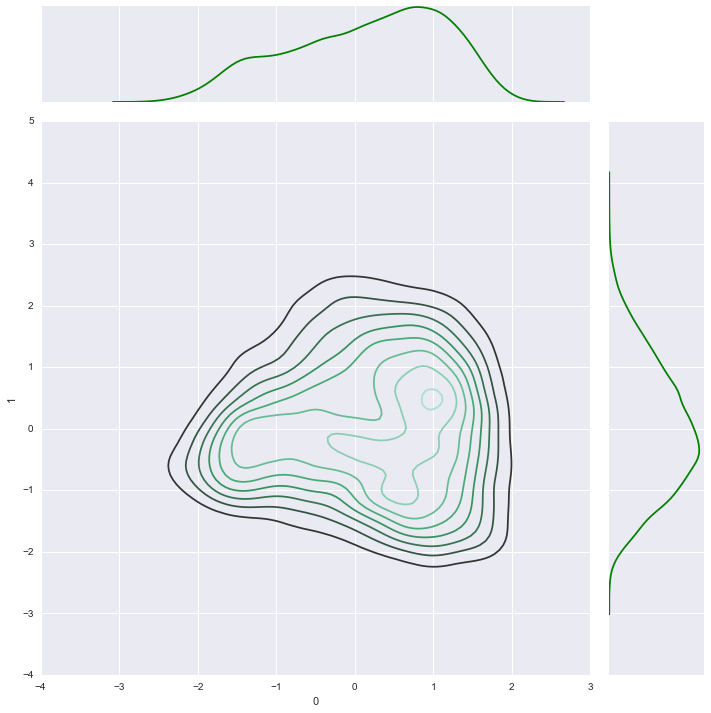

In [62]:
# fig = plt.figure( figsize=(16,10) )
g = sns.JointGrid(0, 1, data=BES_decomp.loc[Leave_inds,0:1], size=10)
g = g.plot_joint(sns.kdeplot, color="g")
g = g.plot_marginals(sns.distplot, kde=True, hist=False, color="g")

# g = g.plot_joint(sns.kdeplot, color="g")
# g = g.plot_marginals(sns.distplot, kde=True, hist=False, color="g")


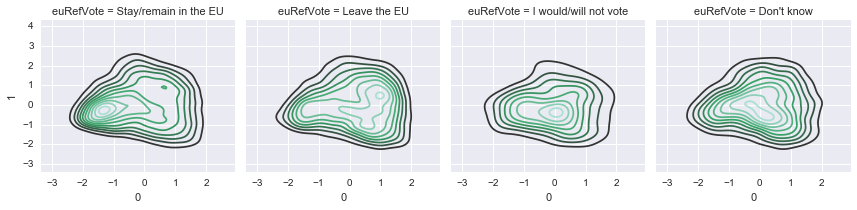

In [98]:
col = "euRefVote"
df = BES_decomp.loc[:,0:1].copy()
df[col] = BES_Panel.loc[df.index,col]

g = sns.FacetGrid(df, col=col,size=3)  
g.map(sns.kdeplot, 0, 1)  
# plt.xlim(0, 250)  
# plt.ylim(0, 60)  

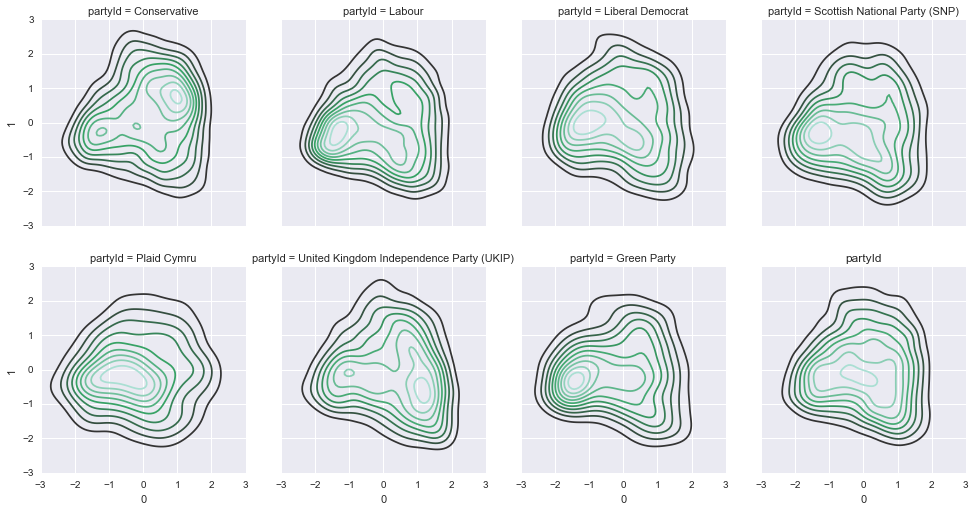

In [161]:
col = "partyId"
df = BES_decomp.loc[:,0:1].copy()
# df.columns = 
df[col] = BES_num_and_cat.loc[df.index,col]

g = sns.FacetGrid(df, col=col,size=3.4,col_wrap=4)  
g.map(sns.kdeplot, 0, 1)  
plt.xlim(-3, 3)  
plt.ylim(-3, 3)

g.savefig(BES_data_folder+Treatment+col, bbox_inches='tight')

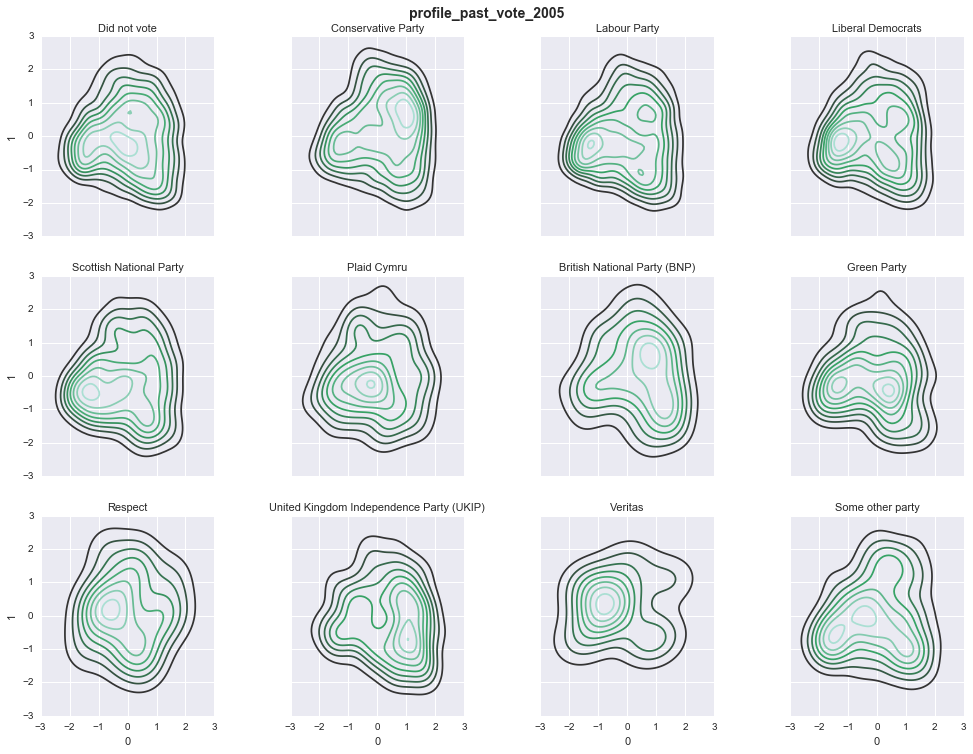

In [174]:
col = "profile_past_vote_2005"
df = BES_decomp.loc[:,0:1].copy()
# df.columns = 
df[col] = BES_num_and_cat.loc[df.index,col]
n_cols = len(df[col].dropna().unique())
g = sns.FacetGrid(df, col=col,size=3.4,col_wrap=4)  
g.map(sns.kdeplot, 0, 1).set_titles("{col_name}")
plt.xlim(-3, 3)  
plt.ylim(-3, 3)
# plt.suptitle(col)
plt.subplots_adjust( top = 1-.15/(n_cols/4) )
g.fig.suptitle(col, fontsize=14, fontweight='bold')
g.savefig(BES_data_folder+Treatment+col+"_kde", bbox_inches='tight')

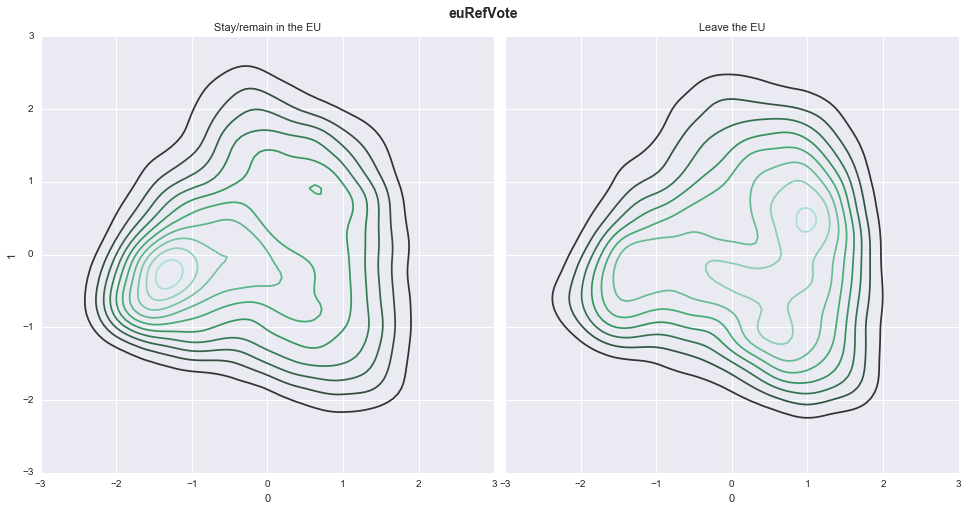

In [185]:
col = "euRefVote"
df = BES_decomp.loc[:,0:1].copy()
max_cols = 4
df[col] = BES_num_and_cat.loc[df.index,col]
n_cols = len(df[col].dropna().unique())
n_rows = np.ceil(n_cols/max_cols)
col_wrap = min(max_cols,n_cols)
size = 13.5/col_wrap
g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
g.map(sns.kdeplot, 0, 1).set_titles("{col_name}")
plt.xlim(-3, 3)  
plt.ylim(-3, 3)
# plt.suptitle(col)
plt.subplots_adjust( top = 1-( .05 + .01*n_rows ) )
g.fig.suptitle(col, fontsize=14, fontweight='bold')
g.savefig(BES_data_folder+Treatment+col+"_kde", bbox_inches='tight')

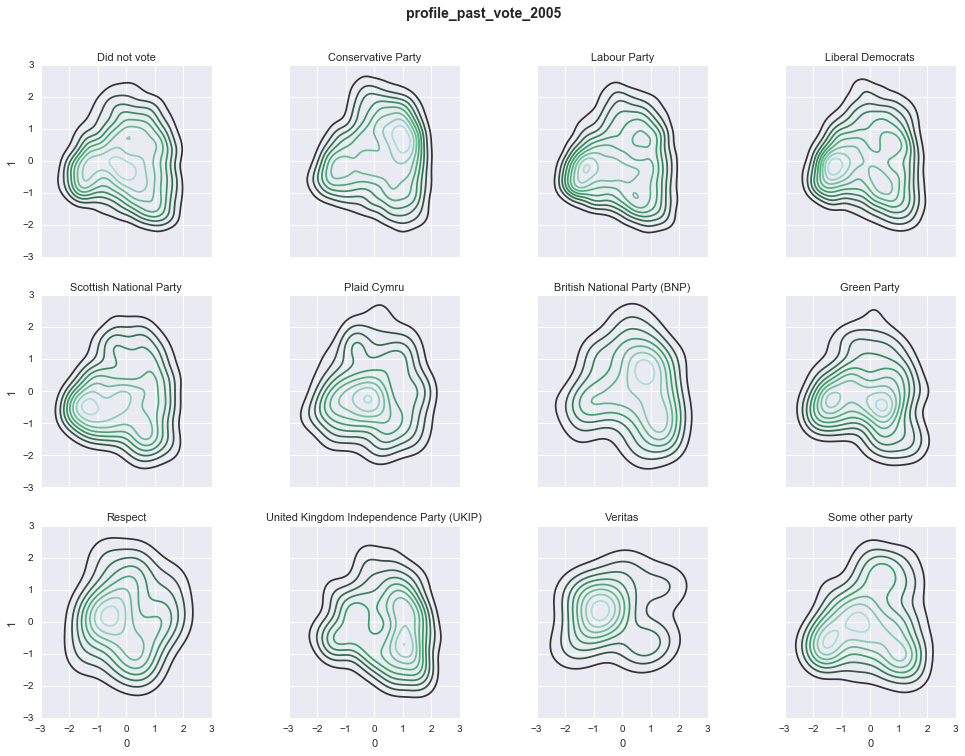

In [188]:
col = "profile_past_vote_2005"
df = BES_decomp.loc[:,0:1].copy()
max_cols = 4
df[col] = BES_num_and_cat.loc[df.index,col]
n_cols = len(df[col].dropna().unique())
n_rows = np.ceil(n_cols/max_cols)
col_wrap = min(max_cols,n_cols)
size = 13.5/col_wrap
g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
g.map(sns.kdeplot, 0, 1).set_titles("{col_name}")
plt.xlim(-3, 3)  
plt.ylim(-3, 3)
# plt.suptitle(col)
plt.subplots_adjust( top = 1-( .05  + .01*n_rows) )
g.fig.suptitle(col, fontsize=14, fontweight='bold')
g.savefig(BES_data_folder+Treatment+col+"_kde", bbox_inches='tight')

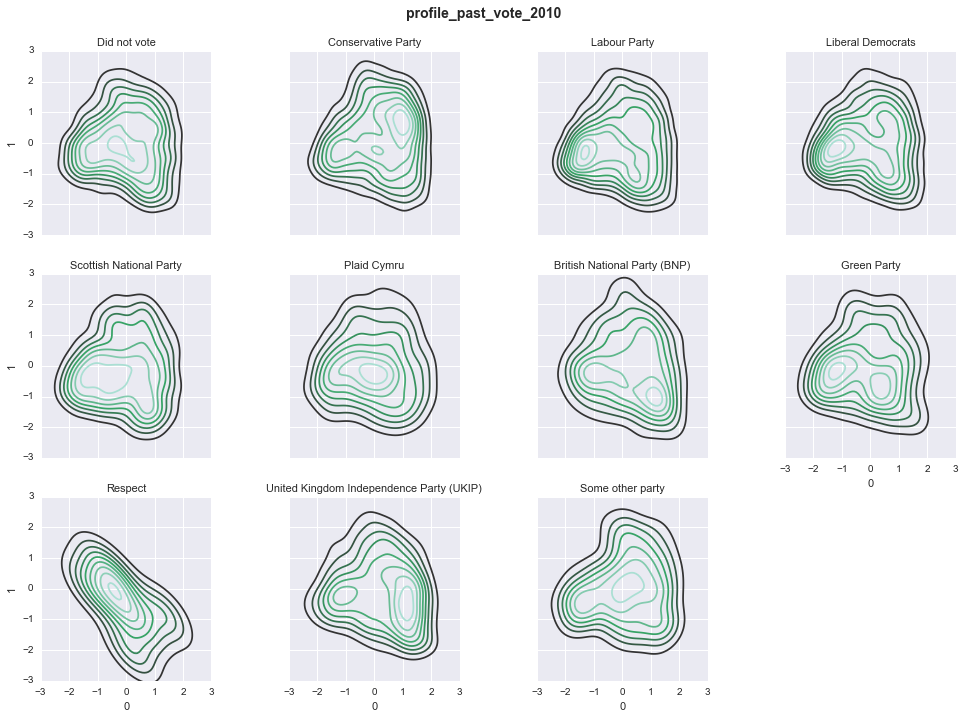

In [190]:
col = "profile_past_vote_2010"
df = BES_decomp.loc[:,0:1].copy()
max_cols = 4
df[col] = BES_num_and_cat.loc[df.index,col]
n_cols = len(df[col].dropna().unique())
n_rows = np.ceil(n_cols/max_cols)
col_wrap = min(max_cols,n_cols)
size = 13.5/col_wrap
g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
g.map(sns.kdeplot, 0, 1).set_titles("{col_name}")
plt.xlim(-3, 3)  
plt.ylim(-3, 3)
# plt.suptitle(col)
plt.subplots_adjust( top = 1-( .05  + .01*n_rows) )
g.fig.suptitle(col, fontsize=14, fontweight='bold')
g.savefig(BES_data_folder+Treatment+col+"_kde", bbox_inches='tight')

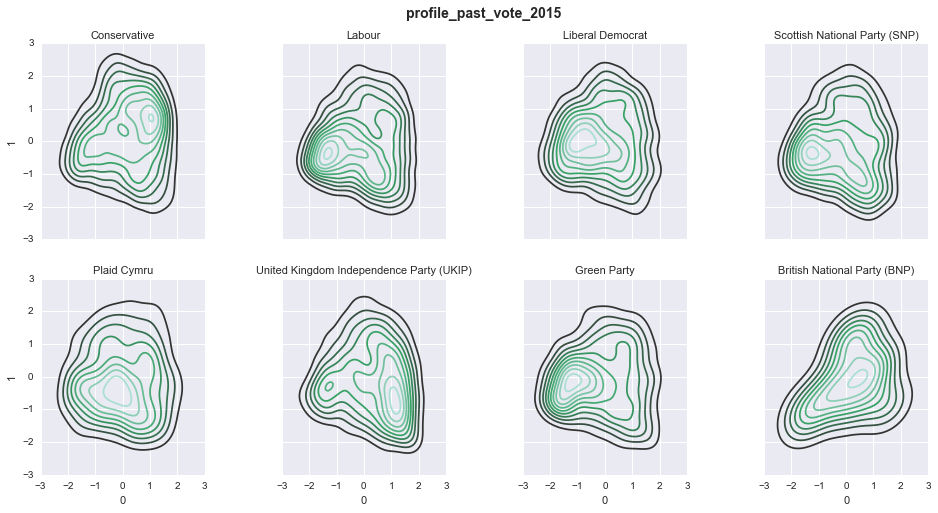

In [191]:
col = "profile_past_vote_2015"
df = BES_decomp.loc[:,0:1].copy()
max_cols = 4
df[col] = BES_num_and_cat.loc[df.index,col]
n_cols = len(df[col].dropna().unique())
n_rows = np.ceil(n_cols/max_cols)
col_wrap = min(max_cols,n_cols)
size = 13.5/col_wrap
g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
g.map(sns.kdeplot, 0, 1).set_titles("{col_name}")
plt.xlim(-3, 3)  
plt.ylim(-3, 3)
# plt.suptitle(col)
plt.subplots_adjust( top = 1-( .05  + .01*n_rows) )
g.fig.suptitle(col, fontsize=14, fontweight='bold')
g.savefig(BES_data_folder+Treatment+col+"_kde", bbox_inches='tight')

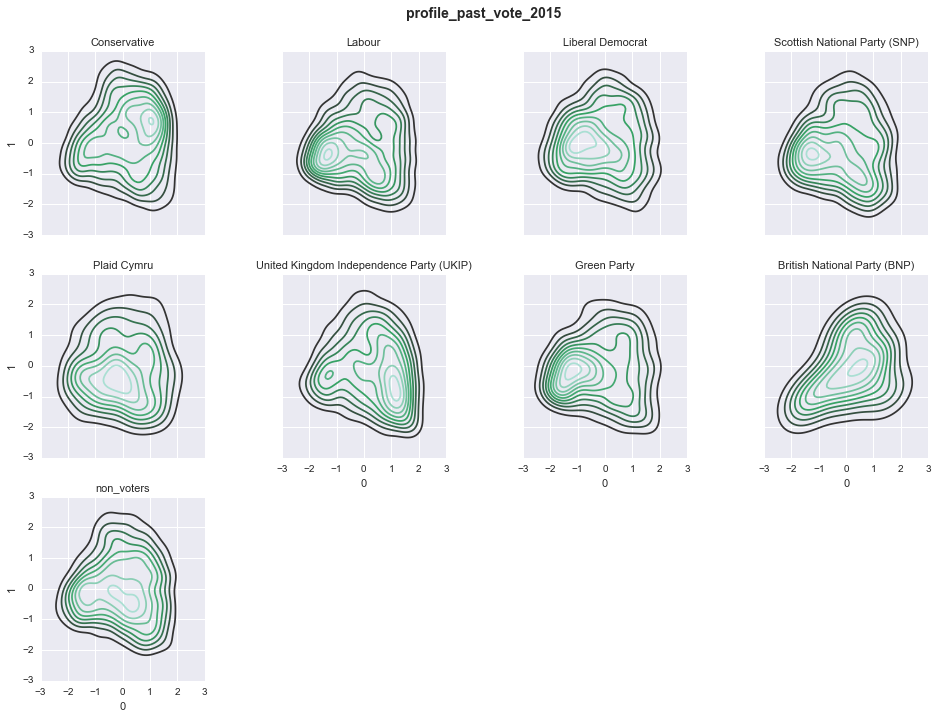

In [224]:

past_non_voters = (BES_Panel["profile_past_vote_2010"]=="Did not vote") | (BES_Panel["profile_past_vote_2005"]=="Did not vote")
non_voters = past_non_voters & BES_Panel["profile_past_vote_2015"].isnull()

col = "profile_past_vote_2015"
df = BES_decomp.loc[:,0:1].copy()
max_cols = 4
df[col] = BES_num_and_cat.loc[df.index,col]
df[col].cat.add_categories(["non_voters"],inplace=True)
df[col][non_voters]="non_voters"
n_cols = len(df[col].dropna().unique())
n_rows = np.ceil(n_cols/max_cols)
col_wrap = min(max_cols,n_cols)
size = 13.5/col_wrap
g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
g.map(sns.kdeplot, 0, 1).set_titles("{col_name}")
plt.xlim(-3, 3)  
plt.ylim(-3, 3)
# plt.suptitle(col)
plt.subplots_adjust( top = 1-( .05  + .01*n_rows) )
g.fig.suptitle(col, fontsize=14, fontweight='bold')
g.savefig(BES_data_folder+Treatment+col+"_kde", bbox_inches='tight')

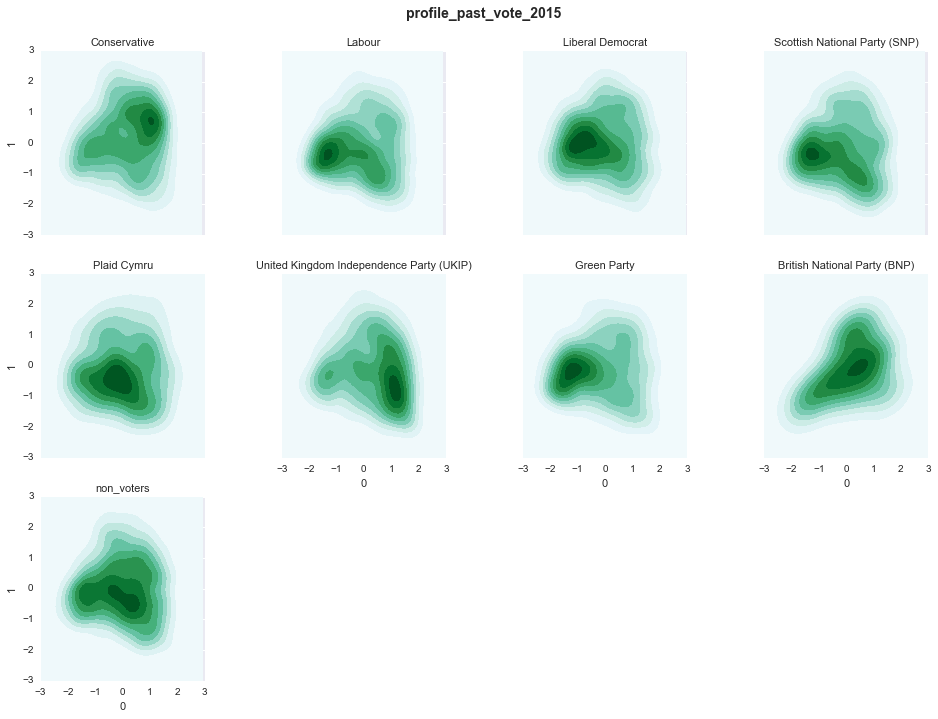

In [225]:

past_non_voters = (BES_Panel["profile_past_vote_2010"]=="Did not vote") | (BES_Panel["profile_past_vote_2005"]=="Did not vote")
non_voters = past_non_voters & BES_Panel["profile_past_vote_2015"].isnull()

col = "profile_past_vote_2015"
df = BES_decomp.loc[:,0:1].copy()
max_cols = 4
df[col] = BES_num_and_cat.loc[df.index,col]
df[col].cat.add_categories(["non_voters"],inplace=True)
df[col][non_voters]="non_voters"
n_cols = len(df[col].dropna().unique())
n_rows = np.ceil(n_cols/max_cols)
col_wrap = min(max_cols,n_cols)
size = 13.5/col_wrap
g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
g.map(sns.kdeplot, 0, 1, shade=True).set_titles("{col_name}")
plt.xlim(-3, 3)  
plt.ylim(-3, 3)
# plt.suptitle(col)
plt.subplots_adjust( top = 1-( .05  + .01*n_rows) )
g.fig.suptitle(col, fontsize=14, fontweight='bold')
g.savefig(BES_data_folder+Treatment+col+"_kde", bbox_inches='tight')

In [ ]:
BES_new = pd.read_hdf(BES_data_folder+"BESW8min.hdf")
import gc
gc.collect()

In [ ]:
len( BES_new.columns[ BES_new.notnull().sum()<13000 ] )

In [ ]:
len( BES_new.columns )

In [ ]:
BES_new.columns[ BES_new.isnull().sum()<1000 ]

In [ ]:
BES_new.columns[ BES_new.isnull().sum()==0 ]

In [ ]:
# 10 interesting variables


# euRefVote, riskTaking, gender, Age
# al2, turkey, subjClass, profile_gross_household, profile_education_age

In [ ]:
BES_new[ ["euRefVote","riskTaking","gender","Age","al2","turkey",
          "profile_gross_household",
          "profile_education_age"   ]  ].fillna(-1).to_stata(BES_data_folder+"BES_W8_just8.dta")

In [ ]:
BES_new[ ["euRefVote","riskTaking","gender","Age","al2","turkey",
          "profile_gross_household", "lr_scale", "al_scale",
          "profile_education_age"   ]  ].fillna(-1).to_stata(BES_data_folder+"BES_W8_just8.dta")

In [ ]:
BES_corr = BES_no_nan.corr()

In [ ]:
BES_corr["euRefVote"].sort_values(ascending=False).head(45)

In [ ]:
BES_no_nan = pd.read_hdf(BES_data_folder+"BESW8knn.hdf")
import gc
gc.collect()

In [ ]:
# create a regression friendly dataframe using patsy's dmatrices function
#y,x = dmatrices(formula, data=BES_no_nan, return_type='dataframe')

y = BES_no_nan["euRefVote"]
x = BES_no_nan.drop("euRefVote",axis=1).drop("euRefVoteW9",axis=1)

In [ ]:
# import the machine learning library that holds the randomforest
import sklearn.ensemble as ske

In [ ]:

# RandomForestClassifier expects a 1 demensional NumPy array, so we convert
y = np.asarray(y).ravel()



In [ ]:
# Random forest
#instantiate and fit our model
results_rf = ske.RandomForestClassifier(n_estimators=100).fit(x, y)

# Score the results
score = results_rf.score(x, y)
print( "Mean accuracy of Random Forest Predictions on the data was: {0}".format(score) )

In [ ]:
pd.concat( [pd.Series ( x.columns),  pd.Series (results_rf.feature_importances_ )], axis=1).sort_values(by=1)

In [ ]:
# Logistic Regression
#instantiate and fit our model
from sklearn.linear_model import LogisticRegression
results_rf = LogisticRegression().fit(x, y)

# Score the results
score = results_rf.score(x, y)
print( "Mean accuracy of Logistic Regression on the data was: {0}".format(score) )


In [ ]:
pd.concat( [pd.Series ( x.columns),  pd.Series (results_rf.coef_[0] )], axis=1).sort_values(by=1)

In [ ]:
BES_no_nan["preschoolChildrenInHousehold"].corr(BES_no_nan["euRefVote"] )

In [ ]:
BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta")

In [ ]:
BES_Panel["turkey"].cat.codes.hist()

In [ ]:
BES_Panel["turkey"].cat.categories

In [ ]:
BES_Panel["EUMIICategory"][euRefVote==1].value_counts()

In [ ]:
BES_Panel["turkey"].cat.codes.corr( BES_Panel["euRefVote"].cat.codes )

In [ ]:
BES_Panel["turkey"].cat.codes.value_counts()

In [ ]:
turkey = BES_Panel["turkey"].cat.codes
turkey[ turkey==5 ] = np.nan

In [ ]:
euRefVote = BES_Panel["euRefVote"].cat.codes
euRefVote[ (euRefVote==3) | (euRefVote==3) ] = np.nan

In [ ]:
turkey.corr(euRefVote)

In [ ]:
death = BES_Panel["al2"].cat.codes
death[ death==5 ] = np.nan

In [ ]:
euRefVote.corr(death)

In [ ]:
BES_Panel["turkey"].value_counts().plot(kind='bar')

In [ ]:
BES_Panel["turkey"].value_counts()

In [ ]:
BES_Panel.groupby('turkey').size().plot(kind='bar')

In [ ]:
BES_Panel[euRefVote==1].groupby('turkey').size().plot(kind='bar')

In [ ]:
BES_Panel[euRefVote==0].groupby('turkey').size().plot(kind='bar')

In [ ]:
BES_Panel["euRefVote"].cat.categories


In [ ]:
BES_Panel["turkey"].cat.codes.hist(by=BES_Panel["euRefVote"],figsize=(30,30))

In [ ]:
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
titanic = sns.load_dataset("titanic")

In [ ]:
sns.countplot(x="euRefVote", hue="turkey", data=BES_Panel, palette="Greens_d");

In [ ]:
sns.countplot(x="euRefVoteW9", hue="turkey", data=BES_Panel, palette="Greens_d");

In [ ]:
sns.countplot(x="immigrantsWelfareState", hue="euRefVoteW9", data=BES_Panel, palette="Greens_d");

In [ ]:
sns.countplot(x="immigContributeTake", hue="euRefVoteW9", data=BES_Panel, palette="Greens_d");

In [ ]:
# immigrantsWelfareState
# antiIntellectualW9
# immigContributeTake

In [ ]:
# Gender and al/lr values

BES_std[["al1", "al2", "al3", "al4","al5", "lr1","lr2","lr3","lr4","lr5"]].corrwith(BES_std["gender"])
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)

# df1.plot(ax=axes[0])
# df2.plot(ax=axes[1])

BES_num_and_cat["al4"][BES_num_and_cat["gender"]=='Female'].value_counts().sort_index().plot(kind='bar', title="Female",ax=axes[0])
(1.0312958987685008*BES_num_and_cat["al4"][BES_num_and_cat["gender"]=='Male'].value_counts().sort_index()).plot(kind='bar', title="Male", ax=axes[1])